# Présentation du notebook
-----------------------
`L'objectif` : réaliser une segmentation de la clientèle Olist en utilisant les données récoltées associées aux commandes clients.


**La première partie de mon travail est de faire un état des lieux de la donnée.**<br>
Tout au long de cette étape, nous analyserons les différentes variables pour tenter de comprendre l'information principale à en retenir et dans quelle mesure elles sont informatives sur la segmentation clientèle.<br>
J'effectuerai également la préparation des données après nettoyage et traitements divers appliquées sur les variables utiles.

# Configuration de l'environnement de travail

Tous les packages et modules utilisées au long de ce notebook ont été au préalablement installés dans l'environnement virtuel.<br>
**Pour identifier les catégories de modules**, reportez-vous aux commentaires dans la cellule de code :

In [97]:
# Import des packages standards & de manipulation de données
import numpy as np
import pandas as pd
from warnings import catch_warnings, filterwarnings

# Import des packages de visualisation
import geopandas as gpd
import seaborn as sns
import squarify as sq
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.ticker import LogFormatter, PercentFormatter, MultipleLocator
from geobr import read_state

# Import du package et des fonctions pour la manipulation de données en SQL
from sqlalchemy import MetaData, create_engine, text

# Définition des fonctions d'utilité générale

Je vais définir plusieurs fonctions d'utilité générale.


La première fonction d'utilité définie ci-dessous permets d'annoter les graphiques de type barplot (unstacked et stacked) avec les valeurs reprentées par chaque barre.

In [98]:
# Création d'une fonction qui permets d'annoter un barplot avec les valeurs au bout de chaque barre
def show_nums_axes(ax, orient="v", fmt=".0g", stacked=False):
    """
    Affiche les valeurs numériques sur les barres d'un graphique à barres.

    Args:
        ax (matplotlib.axes.Axes): L'axe du graphique.
        fmt (str, optional): Format d'affichage des nombres
        orient (str, optional): L'orientation des barres. 'v' pour vertical (par défaut), 'h' pour horizontal.
        stacked (bool, optionnal): S'adapte pour un barstackedplot

    Returns:
        None
    """
    # Error management
    if orient not in ["h", "v"]:
        raise ValueError("orient doit être égal à 'h' ou 'v si spécifié")
    try:
        format(-10.5560, fmt)
    except ValueError:
        raise "Erreur: le format spécifié dans fmt n'est pas correct."
    if not isinstance(stacked, bool):
        raise ValueError("stacked doit être un booléen")
    # Body
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if orient == "v":
            if not stacked:
                ax.annotate(
                    f"{height:{fmt}}" if height != 0 else "",
                    (x + width / 2.0, height),
                    ha="center",
                    va="bottom",
                )
            else:
                ax.annotate(
                    f"{height:{fmt}}",
                    (x + width - 4, y + height / 2),
                    fontsize=10,
                    fontweight="bold",
                    ha="center",
                    va="top",
                )
        else:
            if not stacked:
                ax.annotate(
                    f"{width:{fmt}}" if width != 0 else "",
                    (width, y + height / 2.0),
                    ha="left",
                    va="center",
                )
            else:
                ax.annotate(
                    f"{width:{fmt}}",
                    (x + width - 1, y + height / 2),
                    fontsize=10,
                    fontweight="bold",
                    ha="right",
                    va="center",
                )

La dernière fonction d'utilité est un script pour convertir automatiquement chaque variable au datatype le plus adapté dans un but d'alléger et d'optimiser le dataframe :

In [99]:
# Définition de l'algorithme de conversion
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convertit les types de données d'un DataFrame et optimise la mémoire.

    Args:
        df (pandas.DataFrame): Le DataFrame à traiter.

    Returns:
        pandas.DataFrame: Le DataFrame modifié avec les types de données convertis.

    Description:
        Cette fonction parcourt chaque colonne du DataFrame et effectue les actions suivantes :
        - Optimise le datatype de chaque colonne pour alléger l'utilisation mémoire
        - Pour les valeurs numériques sans NaN, optimise en float, int et uint.
        - Pour les valeurs numériques avec NaN, optimise en float.
        - Pour les chaînes de caractères, optimise le type en string ou en category
        - Seuil par défaut pour category : nbre de valeurs non nulles à la racine carrée
        - Laisse les séries booléenes en bool.
        - Pour les datatype 'object', ordre de conversion : datetime-numeric-string-pass

    Exemple:
        df = pd.read_csv('mon_fichier.csv')
        df = convert_data_types(df)

    Note:
        Cette fonction utilise les modules pandas, numpy et warnings pour gérer les conversions de types
        et supprimer les avertissements.

    """
    # boucle pour convertir
    for col in df:
        if not all(df[col].isna()):
            pattern = df[col].dtype.kind
            match pattern:
                # case float, integer, unsigned
                case "f" | "i" | "u":
                    df[col] = pd.to_numeric(df[col], downcast="unsigned")
                    if pd.api.types.is_float_dtype(df[col]):
                        df[col] = pd.to_numeric(df[col], downcast="float")
                # case object
                case "O":
                    try:
                        with catch_warnings():
                            filterwarnings("ignore")
                            df[col] = pd.to_datetime(df[col], errors="raise")
                    except (ValueError, TypeError):
                        try:
                            df[col] = pd.to_numeric(df[col], downcast="unsigned")
                            if pd.api.types.is_float_dtype(df[col]):
                                df[col] = pd.to_numeric(df[col], downcast="float")
                        except ValueError:
                            try:
                                if (df[col].nunique() + 1) <= np.sqrt(df[col].count()):
                                    df[col] = df[col].astype("category")
                            except ValueError:
                                pass
                # case autres
                case _:
                    pass
        else:  # si la colonne n'a que des valeurs nulles, on laisse le type inchangé
            pass
    # retourne du dataframe modifié
    return df

# Lecture des datasets et analyse des variables

Avant de lire la base de données, je vais lire et enregistrer localement les données géospatiales du Brésil en format geojson.<br>
La lecture des données étant relativement longue, à chaque itération du notebook, il sera plus rapide de commenter ce code et de charger le fichier `brazil_states_geojson` écrit en local.

In [100]:
# Chargement des données géospaciales des états du Brésil
try:
    # Lecture du geodataframe des états du Brésil avec le fichier local en geojson
    brazil_states = gpd.read_file("brazil_states.geojson")
except FileNotFoundError:
    print('Fichier non trouvé. Téléchargement des données géospatiales des états du Brésil en cours...')
    brazil_states = read_state(year=2020, simplified=True)
    brazil_states.to_file("brazil_states.geojson", driver="GeoJSON")
finally:
    print("Données chargées avec succès.")

Données chargées avec succès.


## Création d'une connexion à la base de données

J'utilise le module `sqlalchemy` pour établir une connexion à la base de données OLIST.<br>
Je vais extraire le nom des différentes tables composée la base de données.<br>
Regardons le résultat :

In [101]:
# Création d'engine pour se connecter à la database
engine = create_engine("sqlite:///olist_database.db")

# Lecture de la metadata où est contenu le nom des tables & des champs
metadata = MetaData()
metadata.reflect(bind=engine)

# On affiche le nom des tables
print("Nom des tables:")
print(metadata.tables.keys())

Nom des tables:
dict_keys(['customers', 'geoloc', 'order_items', 'order_pymts', 'order_reviews', 'orders', 'products', 'sellers', 'translation'])


Il est possible d'inspecter le nombre de champs et de lignes par table.<br>
Je pourrai choisir l'approche la plus idéale pour lire les tables en fonction de leur dimensionnalité.

In [102]:
# Exécute un script pour compter le nombre de lignes et de colonnes par table
print(header := f'{"TABLE":<15} | {"NB_CHAMPS":<10} | {"NB_LIGNES":<10}')
print('-' * len(header))
for key in metadata.tables.keys():
    with engine.connect() as con:
        result = con.execute(text(f'SELECT COUNT(*) FROM {key}'))
        n_rows = result.fetchone()[0]
        n_columns = len(metadata.tables[key].columns)
        print(f"{key:<15} | {n_columns:<10} | {n_rows:<10}")

TABLE           | NB_CHAMPS  | NB_LIGNES 
-----------------------------------------
customers       | 6          | 99441     


geoloc          | 6          | 1000163   
order_items     | 8          | 112650    
order_pymts     | 6          | 103886    
order_reviews   | 8          | 99224     
orders          | 9          | 99441     
products        | 10         | 32951     
sellers         | 5          | 3095      
translation     | 3          | 71        


L'ensemble des tables a une dimensionnalité qui ne devrait pas nous poser de problème.<br>
Seule la table geoloc a une nombre de lignes supérieures à 1 000 000.

## CUSTOMERS

Ce dataset est centré autour des clients, customers, et notamment sur la géolocalisation et aussi le nombre de commandes.


Il est en lien avec :
* `ORDERS` lié par clé `customer_id`
    * Chaque commande, order, dans ce dataset a un numéro unique de `customer_id`. Il ne s'agit pas de l'identifiant unique du customer.
    * **Attention**, les customers ont dont un identifiant unique dans `CUSTOMERS`, `customer_unique_id`
* `GEOLOC` lié par clé `customer_zip_code_prefix`
    * Cela permets de géolocaliser les customers. On a plus de détails dans le dataset de géolocalisation si nécessaire.


Voici la description des champs :

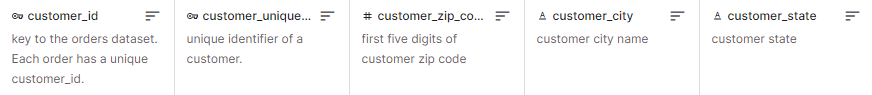

In [103]:
# Lecture de la table customers sous la forme d'un DataFrame Pandas
customers = pd.read_sql_table("customers", con=engine)

# Vérification du nombre de duplicatas ainsi que leur nombre
print(
    "Nombre de duplicatas dans la table : {}\n{}".format(
        customers.duplicated().sum(), "-------"
    )
)
# Affichage du info du dataframe
print(customers.info())

Nombre de duplicatas dans la table : 0
-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     99441 non-null  int64 
 1   customer_id               99441 non-null  object
 2   customer_unique_id        99441 non-null  object
 3   customer_zip_code_prefix  99441 non-null  int64 
 4   customer_city             99441 non-null  object
 5   customer_state            99441 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB
None


Le dataset est complet, il n'y aucune valeur manquante ni duplicata.

Regardons la prévisualisation des 5 première lignes du tableau:

In [104]:
customers.head(5)

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


On regarde pour chaque champs du dataframe le ratio de valeurs uniques par champs.<br>
Je souhaite vérifier que `customer_id` est bien la clé primaire et que `customer_unique_id` est distinct.<br>
Je souhaite connaître aussi les ratios sur les autres colonnes :

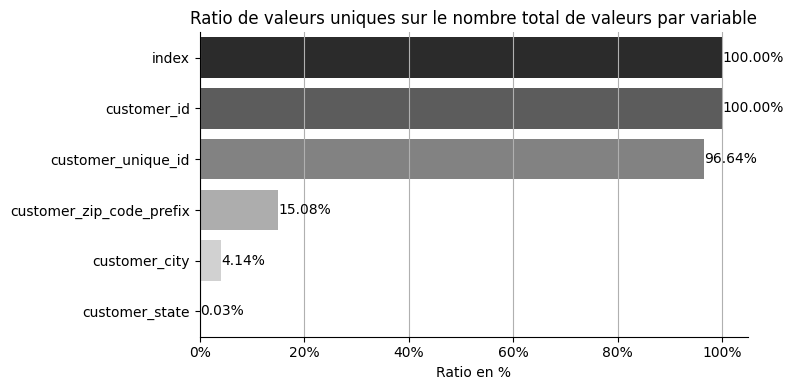

In [105]:
# Création d'un ratio de valeur unique par le compte total de valeurs dans chaque variable :
nunique_count_ratio = customers.nunique() / customers.count()
# Création du plot
fig, ax = plt.subplots(figsize=(8, 4))
(
    sns.barplot(
        y=nunique_count_ratio.index,
        x=nunique_count_ratio.values,
        hue=nunique_count_ratio.index,
        palette="Greys_r",
        ax=ax,
    ).set(
        title="Ratio de valeurs uniques sur le nombre total de valeurs par variable",
        xlabel="Ratio en %",
        ylabel="",
    )
)
ax.grid(axis="x", visible=True)
ax.xaxis.set_major_formatter(PercentFormatter(1))
show_nums_axes(ax=ax, orient="h", fmt=".2%")
sns.despine()
plt.tight_layout()
plt.show()

Je cherche à savoir si on peut trouver un client, avec son `customer_unique_id`, a effectué plusieurs commandes et auraient donc plusieurs numéros de commandes clients avec un `customer_id` différent (lien avec la table orders_dataset). Je regarde le compte de `customer_id`, alias d'une commande, par `customer_unique_id` :

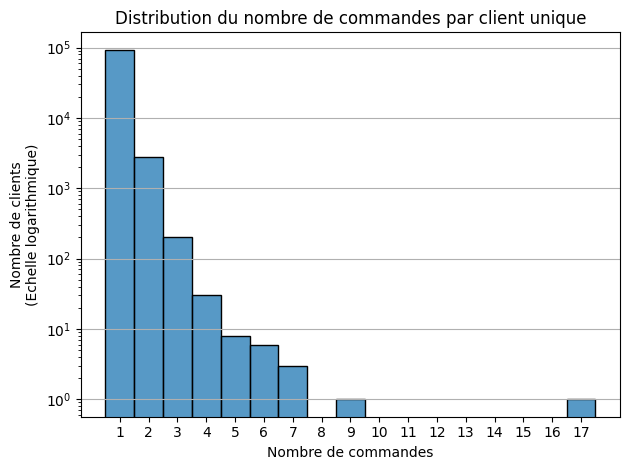

In [106]:
# Calcul du nombre de commandes effectuées par client unique
customers_count = customers["customer_unique_id"].value_counts()
# Création des bornes minimum & maximum pour définir les limites de l'axe X du plot
min_x, max_x = customers_count.min(), customers_count.max() + 1
# Création du plot
ax = plt.subplot(111)
(
    sns.histplot(
        customers_count, bins=customers_count.nunique(), discrete=True, ax=ax
    ).set(
        title="Distribution du nombre de commandes par client unique",
        xlabel="Nombre de commandes",
        ylabel="Nombre de clients\n(Echelle logarithmique)",
    )
)
ax.set_yscale("log")
ax.set_xticks([*range(min_x, max_x)])
ax.grid(axis="y", visible=True)
plt.tight_layout()
plt.show()

Je constate qu'il n'y aucun client qui a effectué plusieurs commandes.<br>
Je regarde les statistiques descriptives sur le nombre de commandes par client:

In [107]:
print(customers_count.describe())

count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: count, dtype: float64


Les données fournies montrent qu'OLIST a filtré les données pour nous fournir principalement des données relatives à une seule commande par client.<br>
Dans ces conditions, la fréquence d'achat moyenne par client dans nos données est donc biaisée, avec **une moyenne de commande par client de 1.03**.<br>
Nous ne pourrons pas nous servir de cet indicateur dans la segmentation.


Je souhaite regarder la territorialité parmi les 27 états du Brésil des données clients fournis à présent:

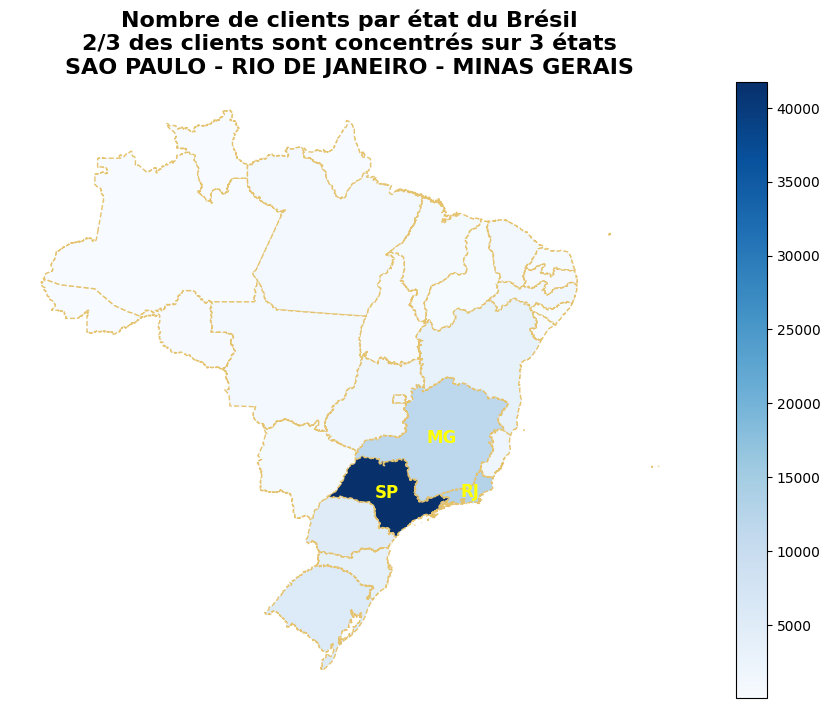

In [108]:
# Calcul du nombre de clients par état représentés dans les données
customer_state_count = customers["customer_state"].value_counts().reset_index()

# Inner join entre le geodataframe et le calcul du nombre de clients par état sur la clé des états
brazil_states_update = brazil_states.merge(
    customer_state_count, left_on="abbrev_state", right_on="customer_state", how="inner"
)
# création du plot avec affichage du top 3 des états
fig, ax = plt.subplots(figsize=(12, 8))
brazil_states_update_crs = brazil_states_update.to_crs("EPSG:5641")
brazil_states_update_crs.plot(
    column="count", cmap="Blues", edgecolor="#E5C36E", linestyle="--", legend=True, ax=ax
)
for x, y, label in zip(
    brazil_states_update_crs.geometry.centroid.x,
    brazil_states_update_crs.geometry.centroid.y,
    brazil_states_update_crs["abbrev_state"],
):
    if label in customer_state_count.nlargest(3, "count").iloc[:, 0].values:
        ax.text(
            x,
            y,
            label,
            fontsize=12,
            color="yellow",
            fontweight="bold",
            ha="center",
            va="center",
        )
ax.set_axis_off()
ax.set_title(
    "Nombre de clients par état du Brésil\n2/3 des clients sont concentrés sur 3 états\nSAO PAULO - RIO DE JANEIRO - MINAS GERAIS",
    fontsize=16,
    fontweight="bold",
)
plt.show()

Il est difficile de savoir s'il s'agit un filtre volontaire sur les clients OLIST et si ce nombre est représentatif de la base de clientèle de OLIST.<br>
Si ces chiffres sont représentatifs, la région du Sud Est serait la plus active avec 3 régions qui cumulent 2/3 des clients.<br>

In [109]:
# Affichage du top3 états avec le plus de clients
brazil_states_update.nlargest(3, "count")

,code_state,abbrev_state,name_state,code_region,name_region,geometry,customer_state,count
19,35.0,SP,São Paulo,3.0,Sudeste,"MULTIPOLYGON (((-48.03716 -25.35794, -48.03750...",SP,41746
18,33.0,RJ,Rio De Janeiro,3.0,Sudeste,"MULTIPOLYGON (((-41.82923 -22.78453, -41.82939...",RJ,12852
16,31.0,MG,Minas Gerais,3.0,Sudeste,"MULTIPOLYGON (((-50.74037 -19.21316, -50.74013...",MG,11635


## SELLERS

Ce dataset est centré autour des vendeurs, customers, et notamment sur la géolocalisation.<br>
Hormis un travail poussé sur la géolocalisation (distance seller/customer et delta temps de livraison), il ne nous sert à rien.


Il est en lien avec :
* `ORDER_ITEMS` lié par clé `seller_id`
* `GEOLOC` lié par clé `seller_zip_code_prefix`
    * Cela permets de géolocaliser les sellers. On a plus de détails dans le dataset de géolocalisation si nécessaire.


Voici la description des champs :

In [110]:
# Lecture de la table sellers sous la forme d'un DataFrame Pandas
sellers = pd.read_sql_table("sellers", con=engine)
# Vérification du nombre de duplicatas ainsi que leur nombre
print(f"Nombre de duplicatas dans la table : {sellers.duplicated().sum()}\n--------")
# Affichage du info du dataframe
print(sellers.info())

Nombre de duplicatas dans la table : 0
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   3095 non-null   int64 
 1   seller_id               3095 non-null   object
 2   seller_zip_code_prefix  3095 non-null   int64 
 3   seller_city             3095 non-null   object
 4   seller_state            3095 non-null   object
dtypes: int64(2), object(3)
memory usage: 121.0+ KB
None


Le dataset est complet, il n'y aucune valeur manquante ni duplicata.

Regardons la prévisualisation:

In [111]:
sellers.head(5)

,index,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


On regarde pour chaque champs du dataframe le ratio de valeurs uniques par champs.<br>


Je souhaite connaître aussi les ratios sur les autres colonnes :

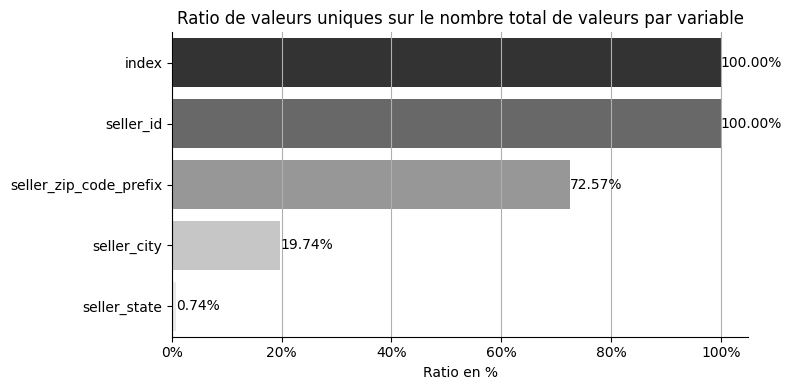

In [112]:
# création d'un ratio de valeur unique par le compte total de valeurs dans chaque variable :
nunique_count_ratio = sellers.nunique() / sellers.count()
# création du plot
fig, ax = plt.subplots(figsize=(8, 4))
(
    sns.barplot(
        y=nunique_count_ratio.index,
        x=nunique_count_ratio.values,
        hue=nunique_count_ratio.index,
        palette="Greys_r",
        ax=ax,
    ).set(
        title="Ratio de valeurs uniques sur le nombre total de valeurs par variable",
        xlabel="Ratio en %",
        ylabel="",
    )
)
ax.grid(axis="x", visible=True)
ax.xaxis.set_major_formatter(PercentFormatter(1))
show_nums_axes(ax=ax, orient="h", fmt=".2%")
sns.despine()
plt.tight_layout()
plt.show()

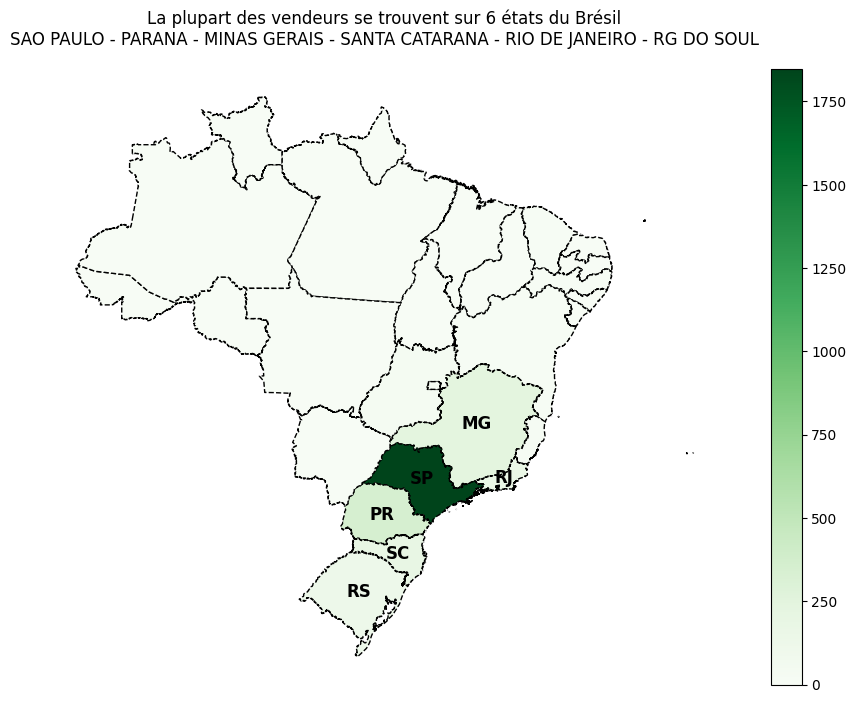

In [113]:
# compte de customer par state
seller_state_count = sellers["seller_state"].value_counts().reset_index()

# merge entre le geodataframe et le count de customer par état
brazil_states_update = brazil_states_update.merge(
    seller_state_count, left_on="abbrev_state", right_on="seller_state", how="left"
).fillna({"count_y": 0})

# création du plot avec affichage du top 3
fig, ax = plt.subplots(figsize=(12, 8))
brazil_states_update_crs = brazil_states_update.to_crs("EPSG:5641")
brazil_states_update_crs.plot(
    column="count_y",
    cmap="Greens",
    edgecolor="black",
    linestyle="--",
    legend=True,
    ax=ax,
)
for x, y, label in zip(
    brazil_states_update_crs.geometry.centroid.x,
    brazil_states_update_crs.geometry.centroid.y,
    brazil_states_update_crs["abbrev_state"],
):
    if label in seller_state_count.nlargest(6, "count").iloc[:, 0].values:
        ax.text(
            x,
            y,
            label,
            fontsize=12,
            color="black",
            fontweight="bold",
            ha="center",
            va="center",
        )
ax.set_axis_off()
ax.set_title(
    "La plupart des vendeurs se trouvent sur 6 états du Brésil\nSAO PAULO - PARANA - MINAS GERAIS - SANTA CATARANA - RIO DE JANEIRO - RG DO SOUL"
)
plt.show()

In [114]:
brazil_states_update_crs.nlargest(6, "count_y")

,code_state,abbrev_state,name_state,code_region,name_region,geometry,customer_state,count_x,seller_state,count_y
19,35.0,SP,São Paulo,3.0,Sudeste,"MULTIPOLYGON (((4439605.517 7100275.413, 44395...",SP,41746,SP,1849.0
20,41.0,PR,Paraná,4.0,Sul,"MULTIPOLYGON (((4398420.157 7040800.322, 43984...",PR,5045,PR,349.0
16,31.0,MG,Minas Gerais,3.0,Sudeste,"MULTIPOLYGON (((4138867.108 7835316.501, 41388...",MG,11635,MG,244.0
21,42.0,SC,Santa Catarina,4.0,Sul,"MULTIPOLYGON (((4376894.497 6728813.545, 43768...",SC,3637,SC,190.0
18,33.0,RJ,Rio De Janeiro,3.0,Sudeste,"MULTIPOLYGON (((5130250.473 7412125.455, 51302...",RJ,12852,RJ,171.0
22,43.0,RS,Rio Grande Do Sul,4.0,Sul,"MULTIPOLYGON (((4254174.816 6603014.458, 42541...",RS,5466,RS,129.0


## GEOLOC

Ce dataset est centré autour de la géolocalisation des villes des customers et sellers.<br>
Il permets de faire de la localisation plus poussée au niveau des villes et éventuellement montrer les villes les plus performantes sur une carte.


Il est en lien avec :
* `SELLERS` et `CUSTOMERS` lié par clé `zip_code_prefix`


Le dataframe étant plus volumineux que les autres et n'ayant pas d'utilité directe à l'exploiter, je ne le chargerai pas ici.


## ORDERS

Ce dataset est un **carrefour** entre `CUSTOMERS`, `ORDER_REVIEWS`, `ORDER_ITEMS` et `ORDER_PYMTS`.<br>
Il est intérressant car il fait le lient entre `CUSTOMERS` et les 3 tables de `ORDER`.<br>
C'est à partir de ces deux tables que nous allons pouvoir construire nos agréggations principales.


Il est en lien avec :
* `ORDERS` lié par clé `order_id`
* `CUSTOMERS` lié par clé `customer_id`


Voici la description des champs :

In [115]:
# Lecture de la table geoloc sous la forme d'un DataFrame Pandas
orders = pd.read_sql_table("orders", con=engine)
# Vérification du nombre de duplicatas ainsi que leur nombre
print(f"Nombre de duplicatas dans la table : {orders.duplicated().sum()}\n--------")
# Affichage du info du dataframe
print(orders.info())

Nombre de duplicatas dans la table : 0
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          99441 non-null  int64 
 1   order_id                       99441 non-null  object
 2   customer_id                    99441 non-null  object
 3   order_status                   99441 non-null  object
 4   order_purchase_timestamp       99441 non-null  object
 5   order_approved_at              99281 non-null  object
 6   order_delivered_carrier_date   97658 non-null  object
 7   order_delivered_customer_date  96476 non-null  object
 8   order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB
None


Le dataset n'est pas complet et il y a des valeurs manquantes sur les variables qui contiennent des dates.<br>

Regardons la prévisualisation:

In [116]:
orders.head(5)

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


On a ici principalement des données relatives aux commandes sur les dates d'achat, approbation et livraison.<br>
On va convertir les data types pour améliorer l'utilisabilité des données avec Pandas :

In [117]:
# Exécution de la fonction de conversion automatisée des data types
(orders := convert_dtypes(orders)).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          99441 non-null  uint32        
 1   order_id                       99441 non-null  object        
 2   customer_id                    99441 non-null  object        
 3   order_status                   99441 non-null  category      
 4   order_purchase_timestamp       99441 non-null  datetime64[ns]
 5   order_approved_at              99281 non-null  datetime64[ns]
 6   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 7   order_delivered_customer_date  96476 non-null  datetime64[ns]
 8   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](5), object(2), uint32(1)
memory usage: 5.8+ MB


Inspectons les ratios de valeurs uniques dans le dataframe :

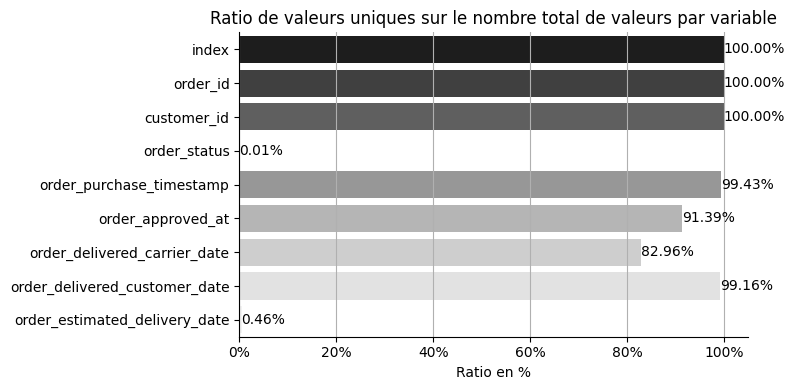

In [118]:
# création d'un ratio de valeur unique par le compte total de valeurs dans chaque variable :
nunique_count_ratio = orders.nunique() / orders.count()
# création du plot
fig, ax = plt.subplots(figsize=(8, 4))
(
    sns.barplot(
        y=nunique_count_ratio.index,
        x=nunique_count_ratio.values,
        hue=nunique_count_ratio.index,
        palette="Greys_r",
        ax=ax,
    ).set(
        title="Ratio de valeurs uniques sur le nombre total de valeurs par variable",
        xlabel="Ratio en %",
        ylabel="",
    )
)
ax.grid(axis="x", visible=True)
ax.xaxis.set_major_formatter(PercentFormatter(1))
show_nums_axes(ax=ax, orient="h", fmt=".2%")
sns.despine()
plt.tight_layout()
plt.show()

Avant de regarder les tables annexes, on va regarder ce que l'on peut apprendre de cette table.<br>
Normalement, customer id et order_id sont liés en one-to-one d'où le ratio de valeurs uniques à 100%.<br>
L'index est uniquement propre à cette table et l'ordre dans lequel elle est présentée.


Intérresons nous déjà aux divers statuts des commandes et leurs proportions:

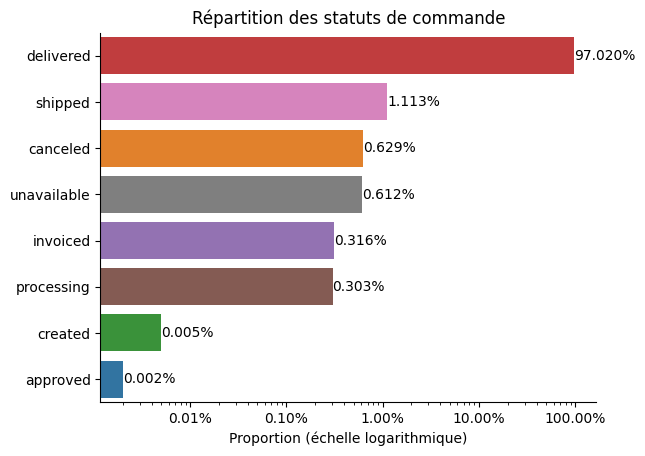

In [119]:
# Création d'un countplot sur les statuts de commande par commande
ax = plt.gca()
sns.countplot(
    data=orders,
    y="order_status",
    hue="order_status",
    order=orders["order_status"].value_counts().index,
    stat="proportion",
    ax=ax,
).set(
    xlabel="Proportion (échelle logarithmique)",
    ylabel="",
    title="Répartition des statuts de commande",
)
ax.set_xscale("log")
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=2))
show_nums_axes(ax=ax, fmt=".3%", orient="h")
sns.despine()
plt.show()

A présent, je vais m'intérresser aux délais de livraison. Je peux comparer les statistiques descriptives des délais estimés et des délais réels.<br>
Etant donné que toutes les commandes n'ont pas été délivrées, on va filtrer les commandes avec le statut délivré.

In [120]:
# Calcul du minimum, moyenne et maximum pour le délai entre la date d'achat et la date d'approbation
(
    orders.loc[orders.order_status == "delivered", :]
    .assign(
        **{
            "delay_purchase_to_approved": lambda x: x.order_approved_at
            - x.order_purchase_timestamp
        }
    )
    .filter(["delay_purchase_to_approved"])
    .agg(["min", "mean", "max"])
)

,delay_purchase_to_approved
min,0 days 00:00:00
mean,0 days 10:16:36.361243572
max,30 days 21:26:37


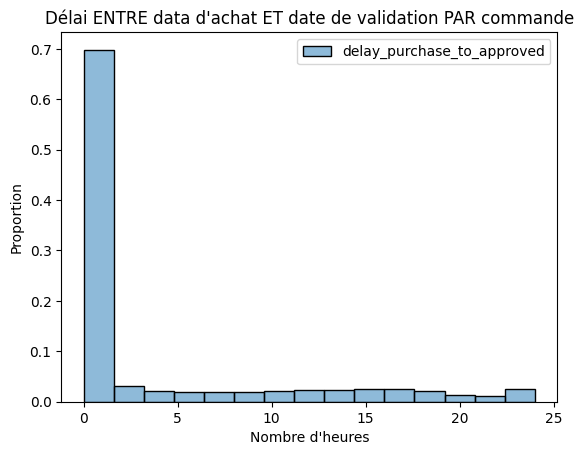

In [121]:
# Histogramme représentant la distribution en proportion du délai entre la date d'achat et la date d'approbation sur toutes les commandes
(
    orders.loc[orders.order_status == "delivered", :]
    .dropna()
    .assign(
        **{
            "delay_purchase_to_approved": lambda x: x.order_approved_at
            - x.order_purchase_timestamp
        }
    )
    .filter(["delay_purchase_to_approved"])
    .transform(lambda x: x.dt.seconds / 60**2)
    .pipe(sns.histplot, stat="proportion", bins=15)
    .set(
        title="Délai ENTRE data d'achat ET date de validation PAR commande",
        xlabel="Nombre d'heures",
    )
)
plt.show()

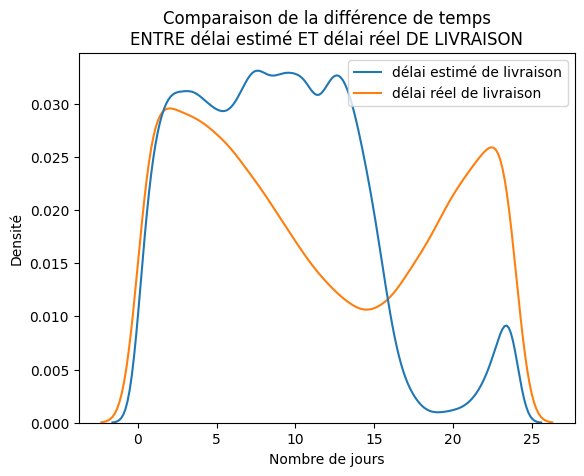

In [122]:
# Comparaison des courbes de densité des commandes délivrées entre le délai estimé et le délai réel de livraison
(
    orders.loc[orders.order_status == "delivered", :]
    .dropna()
    .assign(
        **{
            "délai estimé de livraison": lambda x: x.order_estimated_delivery_date
            - x.order_purchase_timestamp,
            "délai réel de livraison": lambda x: x.order_delivered_customer_date
            - x.order_purchase_timestamp,
        }
    )
    .filter(["délai estimé de livraison", "délai réel de livraison"])
    .transform(lambda x: x.dt.seconds / 3600)
    .pipe(sns.kdeplot)
    .set(
        title="Comparaison de la différence de temps\nENTRE délai estimé ET délai réel DE LIVRAISON",
        xlabel="Nombre de jours",
        ylabel="Densité",
    )
)
plt.show()

In [123]:
# Affichage des stastiques descriptives sur les délais calculés date achat-> date de livraison estimée & date achat -> date de livraison réelle
(
    orders.loc[orders.order_status == "delivered", :]
    .dropna()
    .assign(
        **{
            "delay_purchase_to_estimated": lambda x: x.order_estimated_delivery_date
            - x.order_purchase_timestamp,
            "delay_purchase_to_delivered": lambda x: x.order_delivered_customer_date
            - x.order_purchase_timestamp,
        }
    )
    .filter(["delay_purchase_to_estimated", "delay_purchase_to_delivered"])
    .transform(lambda x: x.dt.seconds / 3600)
    .describe()
)

,delay_purchase_to_estimated,delay_purchase_to_delivered
count,96455.000000,96455.000000
mean,8.726147,11.150216
std,5.333514,7.662582
min,0.000000,0.000000
25%,4.399444,4.252500
50%,8.427778,9.523611
75%,12.331111,18.880139
max,23.999722,23.999444


On constate que les délais réels de livraison sont plus longs en moyenne que les délais estimés.<br>
Au premier quartile, le délai réel est plus court que le délai estimé.
A partir de la médiane, la tendance s'inverse jusqu'à + de 6 jours de différence au 3eme quartile.


On pourrait très bien créer une variable ordinale pour représenter plus simplement les délais et atténuer les valeurs extrêmes.<br>
L'autre possibilité est de créer une variable qui calcule la différence entre le délai estimé et le délai de livraison.


Regardons à présent l'évolution du nombre de commandes dans le temps :

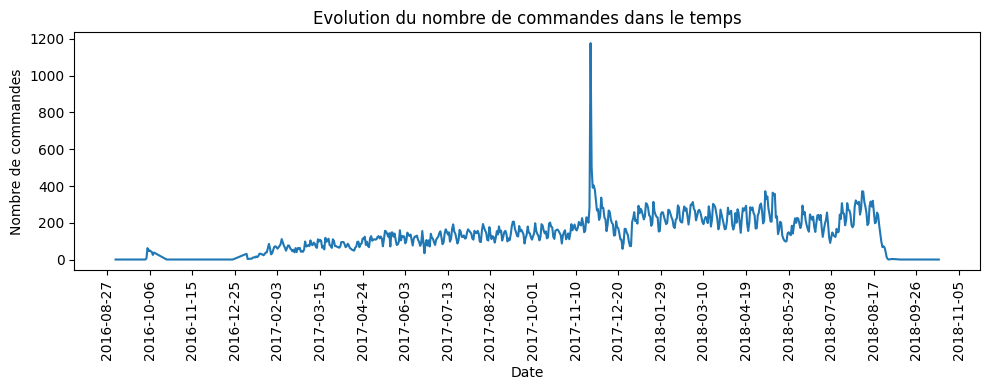

In [124]:
# Lineplot qui représente l'évolution dans le temps du nombre de commandes par jour
fig, ax = plt.subplots(figsize=(10, 4))
(
    orders["order_purchase_timestamp"]
    .dt.date.value_counts()
    .sort_index()
    .reset_index()
    .pipe(sns.lineplot, x="order_purchase_timestamp", y="count", ax=ax)
    .set(
        title="Evolution du nombre de commandes dans le temps",
        xlabel="Date",
        ylabel="Nombre de commandes",
    )
)
ax.xaxis.set_major_locator(MultipleLocator(40))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Je constate qu'il y a des périodes avec peu de commandes en début et en fin de courbe.<br>
Cela peut s'expliquer par une absence de données fournies sur ces périodes par Olist.


Autrement, je note un pic de commandes précédant la période de Noël 2017.<br>
Regardons à présent l'évolution des commandes en sommes cumulées :

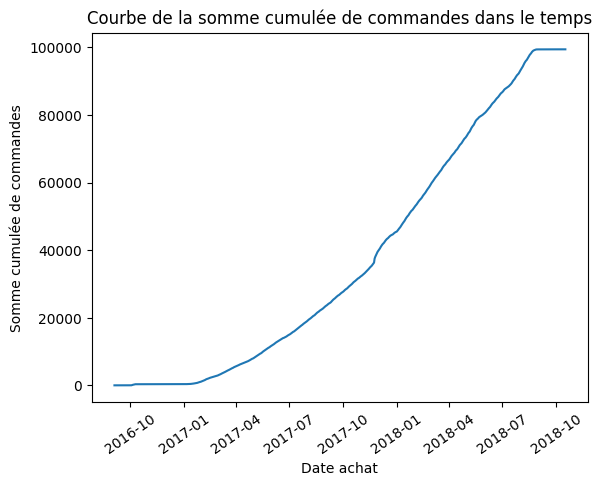

In [125]:
# Lineplot qui montre la courbe de commandes cumulées par jour
(
    orders["order_purchase_timestamp"]
    .dt.date.value_counts()
    .sort_index()
    .cumsum()
    .plot(
        title="Courbe de la somme cumulée de commandes dans le temps",
        xlabel="Date achat",
        ylabel="Somme cumulée de commandes",
        rot=35,
    )
)
plt.show()

In [126]:
# On assigne le calcul de la somme cumulée de commandes par jour sous une array
cumsum_array = (
    orders["order_purchase_timestamp"]
    .dt.date.value_counts()
    .sort_index()
    .cumsum()
    .values
)
# On utilise la fonction gradient pour calculer les dérivées de l'array en chaque point
dy = np.gradient(cumsum_array)

# On détermine un masque pour filtrer les gradients inférieurs à 1 qui indique une partie de courbe en 'plateau'
plateau_index = np.where(np.abs(dy) <= 1)

# afficher les dates continues correspondantes aux index du plateau
plateau_date = (
    orders["order_purchase_timestamp"]
    .dt.date.value_counts()
    .sort_index()
    .index[plateau_index]
)

# On affiche les index et les dates correspondantes
for i, d in zip(plateau_index[0], plateau_date):
    print(f"Index : {i} - Date : {d}")

Index : 0 - Date : 2016-09-04
Index : 1 - Date : 2016-09-05
Index : 2 - Date : 2016-09-13
Index : 3 - Date : 2016-09-15
Index : 13 - Date : 2016-10-22
Index : 621 - Date : 2018-09-10
Index : 622 - Date : 2018-09-11
Index : 623 - Date : 2018-09-12
Index : 624 - Date : 2018-09-13
Index : 625 - Date : 2018-09-17
Index : 626 - Date : 2018-09-20
Index : 627 - Date : 2018-09-25
Index : 628 - Date : 2018-09-26
Index : 629 - Date : 2018-09-29
Index : 630 - Date : 2018-10-01
Index : 631 - Date : 2018-10-03
Index : 632 - Date : 2018-10-16
Index : 633 - Date : 2018-10-17


Hormis pour l'index 13, les autres index sont continus et indiquent un nombre anormalement faible de commande sur ces périodes.<br>
Je vais donc filtrer les commandes à partir de l'index 4 jusqu'à 620.

In [127]:
# on sélectionne les index 4 et 620 pour déterminer la date minimum et maximum du plateau
subset = orders["order_purchase_timestamp"].dt.date.sort_index().iloc[4:620]
print(f"Date plateau minimum: {subset.min()}, date plateau maximum:  {subset.max()}")

Date plateau minimum: 2016-10-05, date plateau maximum:  2018-08-27


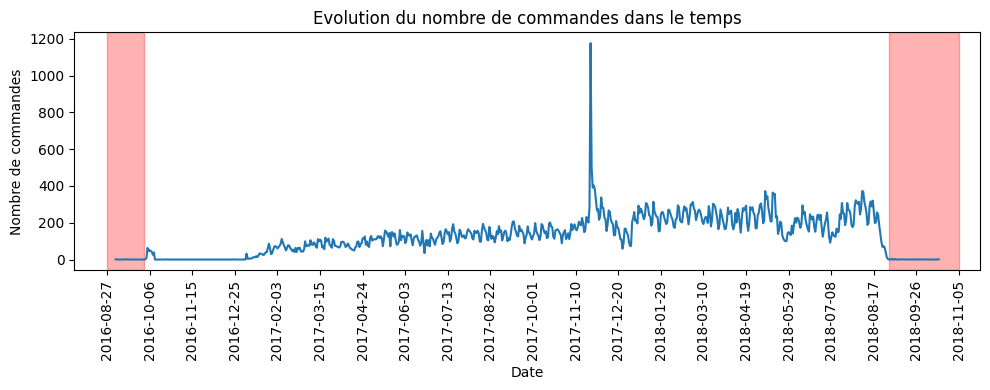

In [128]:
# Lineplot qui représente l'évolution dans le temps du nombre de commandes par jour
fig, ax = plt.subplots(figsize=(10, 4))
(
    orders["order_purchase_timestamp"]
    .dt.date.value_counts()
    .sort_index()
    .asfreq("D", fill_value=0)
    .reset_index()
    .pipe(sns.lineplot, x="order_purchase_timestamp", y="count", ax=ax)
    .set(
        title="Evolution du nombre de commandes dans le temps",
        xlabel="Date",
        ylabel="Nombre de commandes",
    )
)
# Création d'un span à gauche à la date du 2016-10-05
ax.axvspan("2016-08-27", "2016-10-01", color="red", alpha=0.3)
# Création d'un span à droite à la date du 2018-08-27
ax.axvspan("2018-08-31", "2018-11-05", color="red", alpha=0.3)
ax.xaxis.set_major_locator(MultipleLocator(40))
# Rotation des dates de l'axe X
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [129]:
orders["order_purchase_timestamp"].sort_values()

4541    2016-09-04 21:15:19
4396    2016-09-05 00:15:34
10071   2016-09-13 15:24:19
30710   2016-09-15 12:16:38
83078   2016-10-02 22:07:52
                ...        
50387   2018-09-29 09:13:03
88500   2018-10-01 15:30:09
31891   2018-10-03 18:55:29
68373   2018-10-16 20:16:02
60938   2018-10-17 17:30:18
Name: order_purchase_timestamp, Length: 99441, dtype: datetime64[ns]

Je vais inspecter l'évolution du délai moyen, estimé et réel, de livraison au fil du temps et voir si certaines périodes ont été plus propices à des retards :

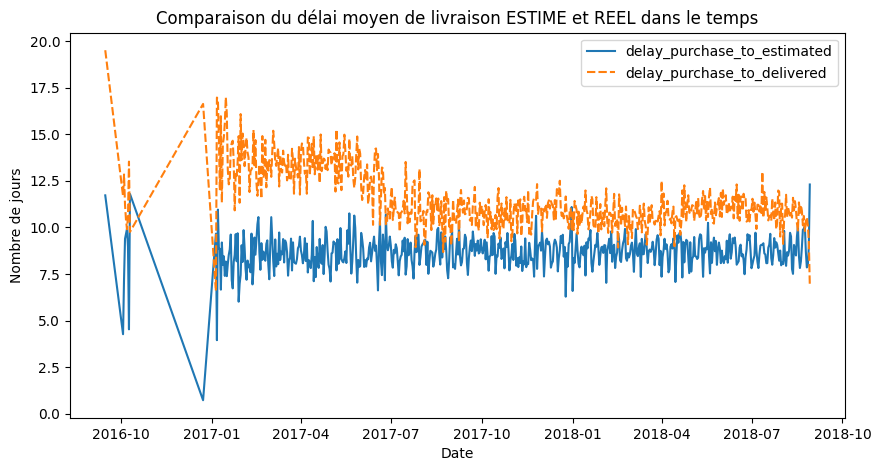

In [130]:
# Figure avec les courbes représentant l'évolution du délai moyen de livraison estimé et réel par commande
fig, ax = plt.subplots(figsize=(10, 5))
# On filtre les commandes délivrées et on ordonne par date d'achat
(
    orders.loc[orders.order_status == "delivered", :]
    .dropna()
    .sort_values("order_purchase_timestamp")
    # On crée les deux colonnes avec le calcul du délai date achat -> date de livraison estimé ET data achat -> date de livraison réelle
    .assign(
        **{
            "delay_purchase_to_estimated": lambda x: (
                x.order_estimated_delivery_date - x.order_purchase_timestamp
            ).dt.seconds
            / 3600,
            "delay_purchase_to_delivered": lambda x: (
                x.order_delivered_customer_date - x.order_purchase_timestamp
            ).dt.seconds
            / 3600,
            "date_of_purchase": lambda x: x.order_purchase_timestamp.dt.date,
        }
    )
    # On effectue un groupby par date d'achat et on calcule la moyenne sur les 2 délais de livraison
    .groupby("date_of_purchase")[
        ["delay_purchase_to_estimated", "delay_purchase_to_delivered"]
    ]
    .mean()
    # On crée le lineplot qui compare les deux courbes dans le temps
    .pipe(sns.lineplot)
    .set(
        title="Comparaison du délai moyen de livraison ESTIME et REEL dans le temps",
        xlabel="Date",
        ylabel="Nombre de jours",
    )
)
plt.show()

La différence entre le délai moyen réel et le délai estimé s'estompe dans le temps et se stabilise entre la mi-2017 jusqu'à fin 2018.

## ORDER _REVIEWS

Ce dataset est un une branche isolée de `ORDERS`<br>
Il donne la satisfaction du client principalement note de 1 à 5, le délai entre l'envoi du questionnaire et la réponse et éventuellement un message.<br>
Les messages étant rares et en portuguais, je ne les analyserai pas.


Il est en lien avec :
* `ORDERS` lié par clé `order_id`


Voici la description des champs :

In [131]:
# Lecture de la table order_reviews sous la forme d'un DataFrame Pandas
order_reviews = pd.read_sql_table("order_reviews", con=engine)
# Vérification du nombre de duplicatas ainsi que leur nombre
print(
    f"Nombre de duplicatas dans la table : {order_reviews.duplicated().sum()}\n--------"
)
# affichage de dataframe info
print(order_reviews.info())

Nombre de duplicatas dans la table : 0
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    99224 non-null  int64 
 1   review_id                99224 non-null  object
 2   order_id                 99224 non-null  object
 3   review_score             99224 non-null  int64 
 4   review_comment_title     11568 non-null  object
 5   review_comment_message   40977 non-null  object
 6   review_creation_date     99224 non-null  object
 7   review_answer_timestamp  99224 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.1+ MB
None


On constate qu'on a un nombre de commande différents probablement du fait que certains n'ont pas encore eu de revues (trop récent ou données manquantes).

In [132]:
order_reviews.head(5)

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


On a ici principalement des données relatives aux commandes sur les dates d'achat, approbation et livraison.<br>
On va convertir les data types pour améliorer l'utilisabilité des données avec Pandas :

In [133]:
# On éxecute la fonction de conversion des dtypes et on affiche l'info résultant
(order_reviews := convert_dtypes(order_reviews)).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    99224 non-null  uint32        
 1   review_id                99224 non-null  object        
 2   order_id                 99224 non-null  object        
 3   review_score             99224 non-null  uint8         
 4   review_comment_title     11568 non-null  object        
 5   review_comment_message   40977 non-null  object        
 6   review_creation_date     99224 non-null  datetime64[ns]
 7   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(4), uint32(1), uint8(1)
memory usage: 5.0+ MB


Le dataset n'est pas complet en raison de valeurs manquantes sur les champs de commentaires et leurs titres.<br>
Je passe à l'inspection des ratios de valeurs uniques :

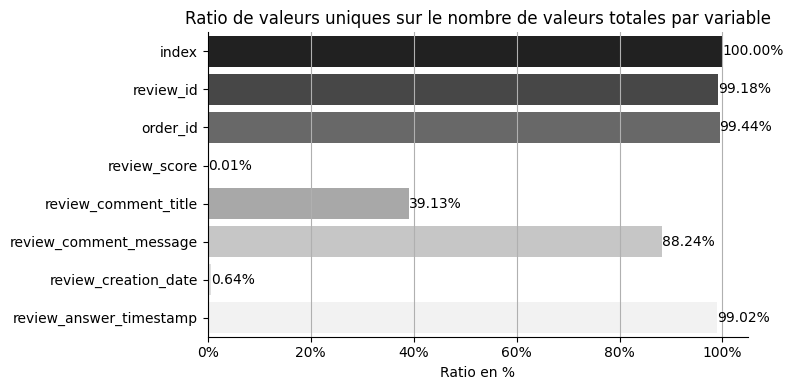

In [134]:
# création d'un ratio de valeur unique par le compte total de valeurs dans chaque variable :
nunique_count_ratio = order_reviews.nunique() / order_reviews.count()
# création du plot
fig, ax = plt.subplots(figsize=(8, 4))
(
    sns.barplot(
        y=nunique_count_ratio.index,
        x=nunique_count_ratio.values,
        hue=nunique_count_ratio.index,
        palette="Greys_r",
        ax=ax,
    ).set(
        title="Ratio de valeurs uniques sur le nombre de valeurs totales par variable",
        xlabel="Ratio en %",
        ylabel="",
    )
)
ax.grid(axis="x", visible=True)
ax.xaxis.set_major_formatter(PercentFormatter(1))
show_nums_axes(ax=ax, orient="h", fmt=".2%")
sns.despine()
plt.tight_layout()
plt.show()

Je vais m'intérresser à la répartition des notes données par les clients :

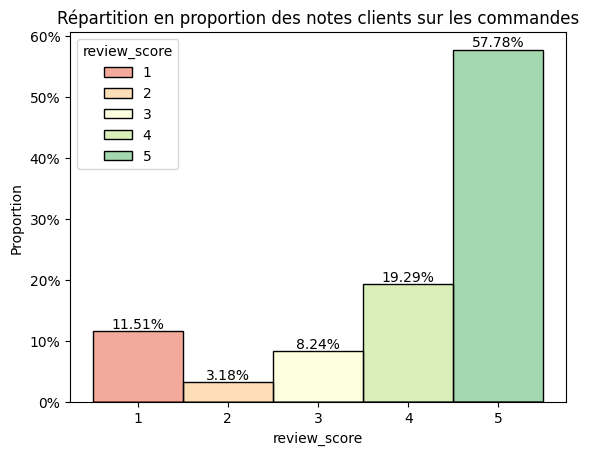

In [135]:
# Barplot avec la réparttion en proportion des notes sur l'ensemble des commandes
ax = plt.gca()
# Créer une palette de couleur divergente du rouge au vert
colors = sns.color_palette("RdYlGn", n_colors=5)
(
    sns.histplot(
        data=order_reviews,
        x="review_score",
        discrete=True,
        hue="review_score",
        palette=colors,
        stat="proportion",
        ax=ax,
    ).set(title="Répartition en proportion des notes clients sur les commandes")
)
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
show_nums_axes(ax=ax, fmt=".2%", orient="v")
plt.show()

In [136]:
# Affichage des statistiques descriptives sur le champs des notes
print(order_reviews["review_score"].describe())

count    99224.000000
mean         4.086421
std          1.347579
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64


La note moyenne est de 4 avec une grande majorité de notes, environ 85%, entre 3 et 5.<br>
Moins de 15% des notes ont été donnée entre 1 et 2.<br>
On note tout de même une proportion non négligeable de clients qui ont donné la note de 1 avec 11,51%.

## ORDER_PYMTS

Ce dataset est un une branche isolée de `ORDERS`<br>
Il donne le montant du paiement de la commande, panier, aussi le nombre d'échéances choisies par le client, le type de paiement et le nombre de moyens de paiement différents utilisés lors de la commande<br>
En dehors du nombre de moyen de paiements, les autres variables sont intérressanters à analyser pour notre segmentation.

Il est en lien avec :
* `ORDERS` lié par clé `order_id`


Voici la description des champs :

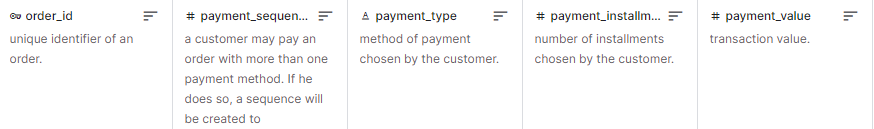

In [137]:
# Lecture de la table order_pymts sous la forme d'un DataFrame Pandas
order_pymts = pd.read_sql_table("order_pymts", con=engine)
# Vérification du nombre de duplicatas ainsi que leur nombre
print(
    f"Nombre de duplicatas dans la table : {order_pymts.duplicated().sum()}\n--------"
)
# affichage de dataframe info
print(order_pymts.info())

Nombre de duplicatas dans la table : 0
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 103886 non-null  int64  
 1   order_id              103886 non-null  object 
 2   payment_sequential    103886 non-null  int64  
 3   payment_type          103886 non-null  object 
 4   payment_installments  103886 non-null  int64  
 5   payment_value         103886 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.8+ MB
None


Le dataset est complet et n'a aucune valeur manquante.<br>

In [138]:
order_pymts.head(5)

,index,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


On inspecte les ratios de valeurs uniques sur valeur totale sur notre table :

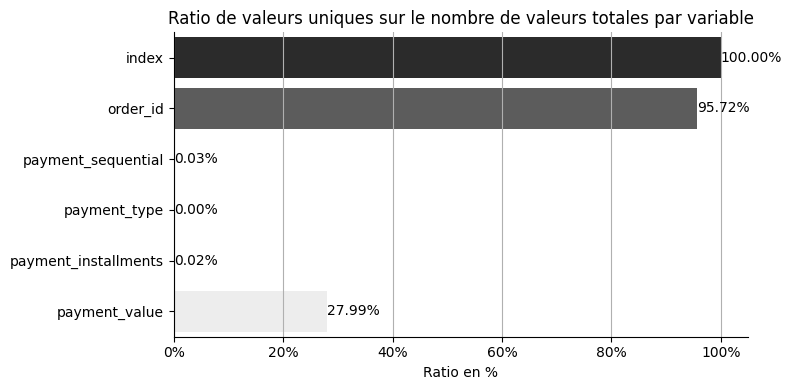

In [139]:
# création d'un ratio de valeur unique par le compte total de valeurs dans chaque variable :
nunique_count_ratio = order_pymts.nunique() / order_pymts.count()
# création du plot
fig, ax = plt.subplots(figsize=(8, 4))
(
    sns.barplot(
        y=nunique_count_ratio.index,
        x=nunique_count_ratio.values,
        hue=nunique_count_ratio.index,
        palette="Greys_r",
        ax=ax,
    ).set(
        title="Ratio de valeurs uniques sur le nombre de valeurs totales par variable",
        xlabel="Ratio en %",
        ylabel="",
    )
)
ax.grid(axis="x", visible=True)
ax.xaxis.set_major_formatter(PercentFormatter(1))
show_nums_axes(ax=ax, orient="h", fmt=".2%")
sns.despine()
plt.tight_layout()
plt.show()

Une même commande peut avoir plusieurs moyens de paiement différents.<br>
Vérifions cela avec le compte:

In [140]:
# Affichage des statistiques descriptives sur le champs order_id
order_pymts.order_id.value_counts().describe()

count    99440.000000
mean         1.044710
std          0.381166
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         29.000000
Name: count, dtype: float64

En toute logique, on devrait trouver une quasi-similaire entre order_id et payment sequential :

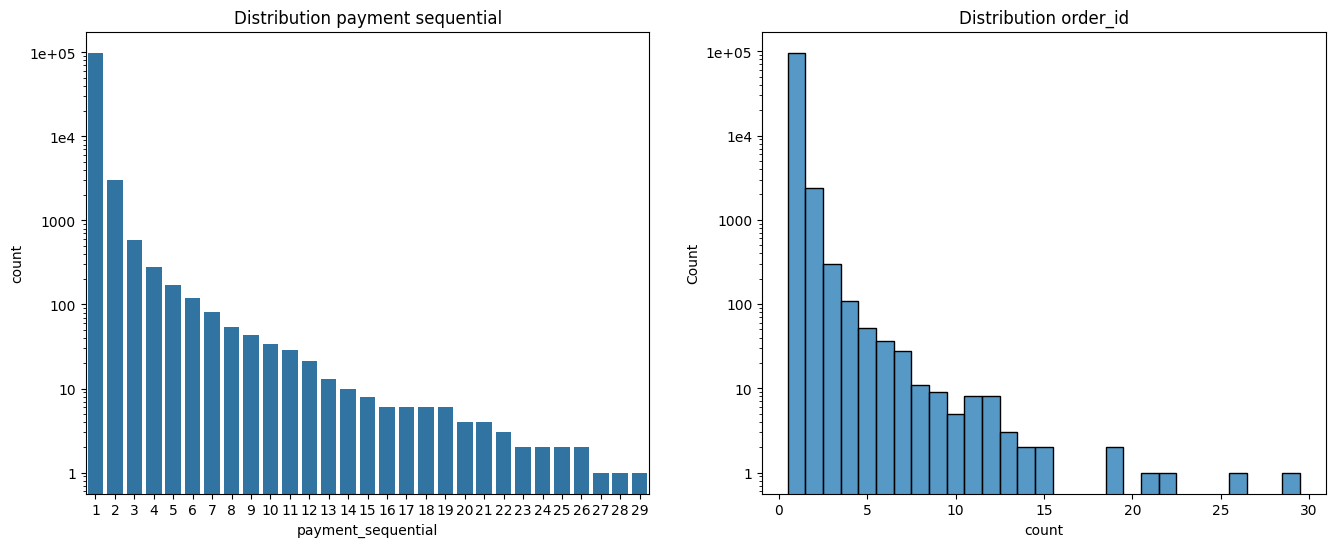

In [141]:
# Création d'un countplot pour le champs payment_sequential
fig = plt.figure(figsize=(16, 6))
ax = plt.subplot(121)
sns.countplot(data=order_pymts, x="payment_sequential", ax=ax).set(
    yscale="log", title="Distribution payment sequential"
)
ax.yaxis.set_major_formatter(LogFormatter(base=10))
# Création d'un histogramme pour le compte des unique order_id
ax = plt.subplot(122)
sns.histplot(order_pymts["order_id"].value_counts(), discrete=True, ax=ax).set(
    yscale="log", title="Distribution order_id"
)
ax.yaxis.set_major_formatter(LogFormatter(base=10))
plt.show()

Les commandes qui ont utilisés plusieurs moyens de paiement restent une minorité dans nos données et on voit que certains clients ont utilisé de manière assez suprenante jusqu'à 29 moyens de paiement différents.


Regardons le moyen de paiement préféré sur les commandes :

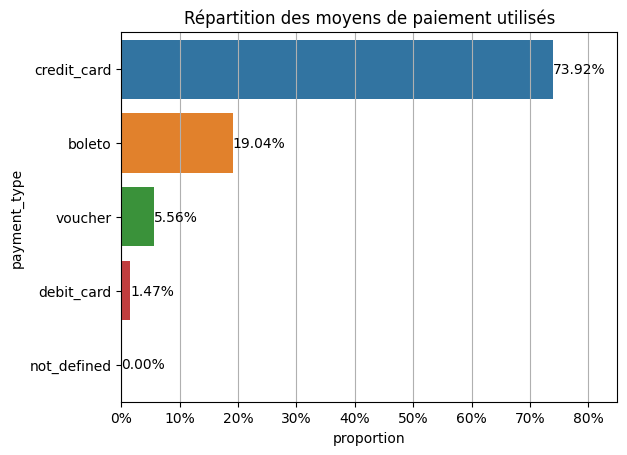

In [142]:
# Création d'un countplot en proportion sur le champs des moyens de paiement utilisés par paiement
ax = plt.gca()
sns.countplot(
    data=order_pymts, y="payment_type", hue="payment_type", stat="proportion", ax=ax
).set(xlim=(0.0, 0.85), title="Répartition des moyens de paiement utilisés")
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.grid(axis="x", visible=True)
show_nums_axes(ax=ax, orient="h", fmt=".2%")
plt.show()

Il est intérressant de voir que le `boleto`, moyen de paiement très prisé au Brésil, ait une proportion aussi importante, 19%. <br>
Pour la segmentation, il sera difficile d'utiliser cette variable comme elle peut comporter différent types de paiement par commande.

In [143]:
# Affichage des statistiques descriptives sur le champs payment_value
order_pymts["payment_value"].describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

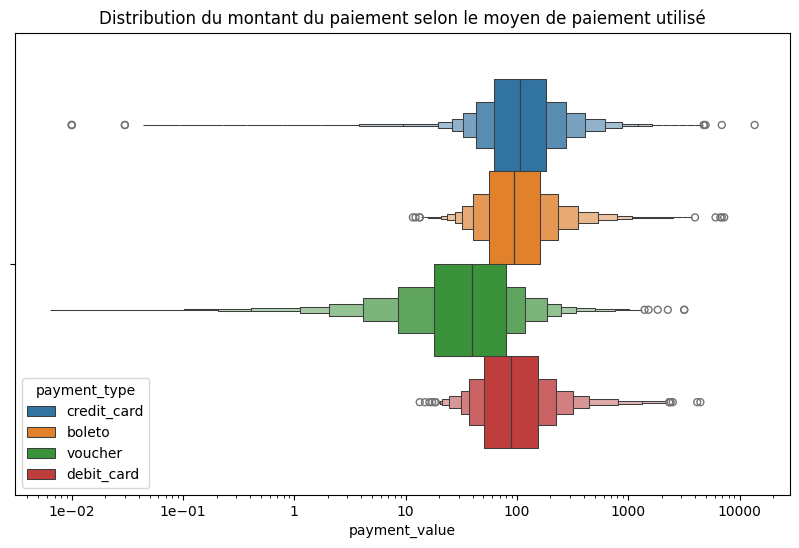

In [144]:
# Comparaison de la distribution de la valeur des paiements en fonction du moyen de paiement sous forme de boxenplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxenplot(
    data=order_pymts.loc[order_pymts["payment_type"] != "not_defined", :],
    x="payment_value",
    hue="payment_type",
    ax=ax,
).set(
    xscale="log",
    title="Distribution du montant du paiement selon le moyen de paiement utilisé",
)
ax.xaxis.set_major_formatter(LogFormatter(base=10))
plt.show()

On constate que le `voucher`, coupons de réduction, corresponds à des petites sommes et différe des trois autres types de paiement.<br>
L'utilisation de la `credit_card` est utilisé à tout fin, petit comme gros moyen de paiement.<br>
Enfin le `boleto` et `debit_card` ont sensiblement le même type de distribution.

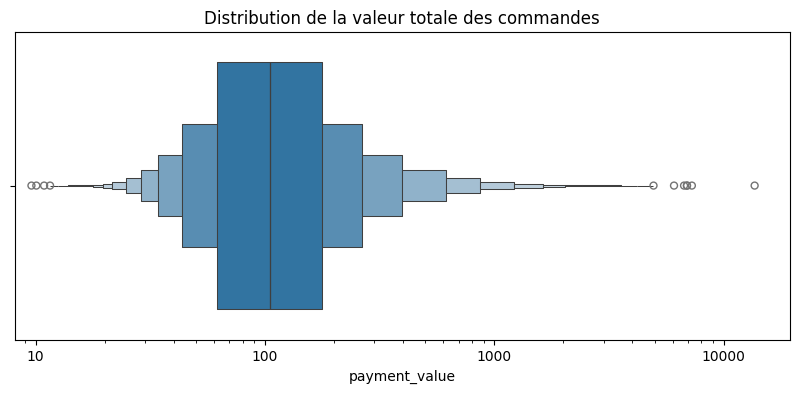

In [145]:
# création d'un objet groupby
order_groupby = order_pymts.groupby("order_id")["payment_value"].sum()
# plot de la distribution du montant du paiement sous forme de boxenplot
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x=order_groupby, ax=ax).set(
    xscale="log", title="Distribution de la valeur totale des commandes"
)
ax.xaxis.set_major_formatter(LogFormatter(base=10))
plt.show()

In [146]:
print(f"""Calcul des stastiques générales sur les commandes:
Moyenne: {order_groupby.mean():.2f}
Ecart-type: {order_groupby.std():.2f}
Médiane : {order_groupby.median():.2f}
Minimum: {order_groupby.min():.4f}
Maximum: {order_groupby.max():.2f}""")

Calcul des stastiques générales sur les commandes:
Moyenne: 160.99
Ecart-type: 221.95
Médiane : 105.29
Minimum: 0.0000
Maximum: 13664.08


On voit effectivement sur le graphique et les statistiques descriptives qu'on a une asymétrie prononcée sur la droite.<br>
On trouve aussi une commande à 0 euros en minimum.<br>
Afin de mieux visualiser la distribution de la variable, on va effectuer une transformation logarithmique en base 10 et filter les valeurs supérieures à 0:

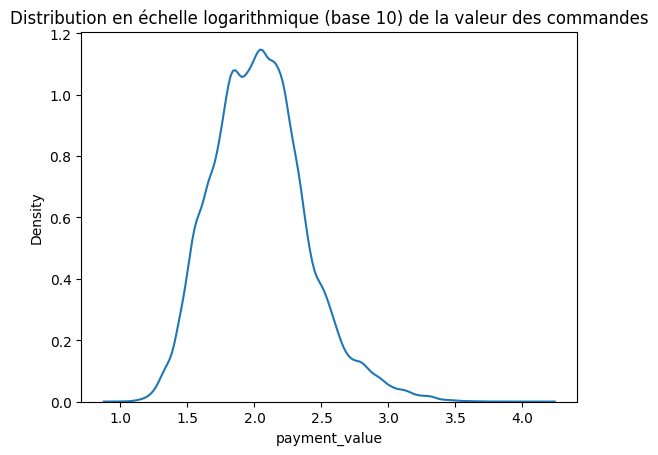

In [147]:
# Création d'une courbe de densité sur la somme totale des paiements par commande
order_groupby = order_pymts.groupby("order_id")["payment_value"].sum()
sns.kdeplot(np.log10(order_groupby[order_groupby > 0])).set(
    title="Distribution en échelle logarithmique (base 10) de la valeur des commandes"
)
plt.show()

Enfin on peut regarder le nombre d'échéances avec `payment_installments` et vérifier qu'ils sont propres à chaque séquence de paiement:

In [148]:
# Affichage du head trié par les valeurs de order_id pour montrer les commandes qui utilisent plusieurs paiements et moyens de paiement.
(
    order_pymts.loc[order_pymts.duplicated(subset="order_id", keep=False), :]
    .sort_values("order_id")
    .head(10)
)

,index,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
20036,20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
30155,30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
10244,10244,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100.00
16459,16459,009ac365164f8e06f59d18a08045f6c4,2,voucher,1,4.50
15298,15298,009ac365164f8e06f59d18a08045f6c4,6,voucher,1,4.17
32058,32058,009ac365164f8e06f59d18a08045f6c4,4,voucher,1,5.45
285,285,009ac365164f8e06f59d18a08045f6c4,5,voucher,1,8.75


C'est bien le cas.<br>
On constate déjà que ce sont principalement les vouchers qui sont utilisés pour des petites sommes.<br>
Je vais visualiser maintenant la distribution de la valeur de paiement selon le nombre d'échéances à l'instar du type de paiement.

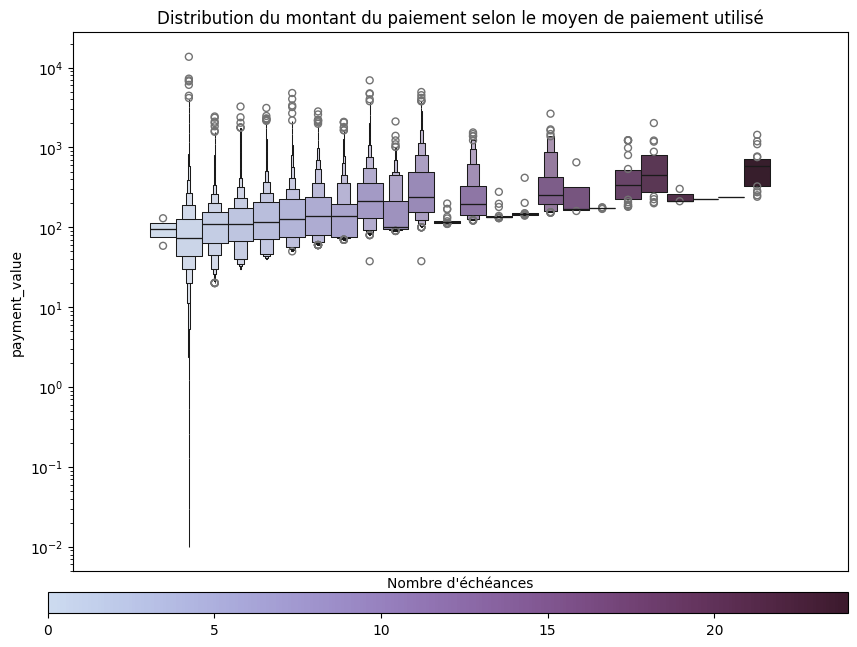

In [149]:
# création du plot qui va comparer toutes les distribution du montant total d'une commande en fonction du nombre d'échéances par commande
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxenplot(
    data=order_pymts.loc[order_pymts["payment_type"] != "not_defined", :],
    y="payment_value",
    hue="payment_installments",
    palette="ch:0.8, -0.4",
    ax=ax,
).set(
    yscale="log",
    title="Distribution du montant du paiement selon le moyen de paiement utilisé",
    xlabel="Nombre d'échéances",
    xticks=[],
)
ax.xaxis.set_major_formatter(LogFormatter(base=10))
# On adapte les bornes des échéances aux couleurs de la palette en vue de faire une colorbar
norm = mcolors.Normalize(
    vmin=order_pymts["payment_installments"].min(),
    vmax=order_pymts["payment_installments"].max(),
)
cmap = sns.cubehelix_palette(start=0.8, rot=-0.4, as_cmap=True)
# Créer un ScalarMappable pour mapper les valeurs normalisées à la palette de couleurs
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # cette ligne est nécessaire pour le mappable
# Créer un nouvel axe pour plotter la colorbar en dessous du graphique
cax = fig.add_axes(
    [0.1, 0.05, 0.8, 0.03]
)  # ajuster ces valeurs pour positionner la colorbar
plt.colorbar(sm, cax=cax, orientation="horizontal")
# Ne pas afficher la légende
ax.legend([], [], frameon=False)
plt.show()

On constate l'évolution du prix de la commande en fonction du nombre d'échéances requises avec évidement une grande disparité pour 1 échéance.<br>
Surprenament, on trouve des commandes avec 0 échéance.

In [150]:
# On affiche une commande avec 0 échéance
print(order_pymts.loc[order_pymts["payment_installments"].argmin(), :])
# Nombre de commandes avec 0 échéance
print(
    "Nombre de lignes qui ont échéance égale à 0: {} lignes".format(
        order_pymts.loc[
            order_pymts["payment_installments"] == 0, "payment_installments"
        ].count()
    )
)

index                                              46982
order_id                744bade1fcf9ff3f31d860ace076d422
payment_sequential                                     2
payment_type                                 credit_card
payment_installments                                   0
payment_value                                      58.69
Name: 46982, dtype: object
Nombre de lignes qui ont échéance égale à 0: 2 lignes


## ORDER_ITEMS

Ce dataset est un une branche isolée de `ORDERS`<br>
Il donne l'ordre d'ajout des items dans le panier (peu de variance), l'id du produit associé, le vendeur, le prix du produit, item/product, date de livraison limite, valeur des frais de ports.<br>
Beaucoup d'informations très utiles à examiner.

Il est en lien avec :
* `ORDERS` lié par clé `order_id`


Voici la description des champs :

In [151]:
# Lecture de la table order_items sous la forme d'un DataFrame Pandas
order_items = pd.read_sql_table("order_items", con=engine)
# Vérification du nombre de duplicatas ainsi que leur nombre
print(
    f"Nombre de duplicatas dans la table : {order_items.duplicated().sum()}\n--------"
)
# affichage de dataframe info
print(order_items.info())

Nombre de duplicatas dans la table : 0
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                112650 non-null  int64  
 1   order_id             112650 non-null  object 
 2   order_item_id        112650 non-null  int64  
 3   product_id           112650 non-null  object 
 4   seller_id            112650 non-null  object 
 5   shipping_limit_date  112650 non-null  object 
 6   price                112650 non-null  float64
 7   freight_value        112650 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB
None


Le champs `shipping_limit_date` n'est pas converti en datetime.

In [152]:
# Calcul du nombre de valeurs uniques par colonne
print(order_items.nunique())

index                  112650
order_id                98666
order_item_id              21
product_id              32951
seller_id                3095
shipping_limit_date     93318
price                    5968
freight_value            6999
dtype: int64


On va convertir les champs dans un format plus correct:

In [153]:
order_items = convert_dtypes(order_items)

Le dataset est complet et n'a aucune valeur manquante.<br>

In [154]:
order_items.head(5)

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.900002,13.290000
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.899994,19.930000
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.000000,17.870001
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.990000,12.790000
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.899994,18.139999


On inspecte les ratios de valeurs uniques sur valeur totale sur notre table :

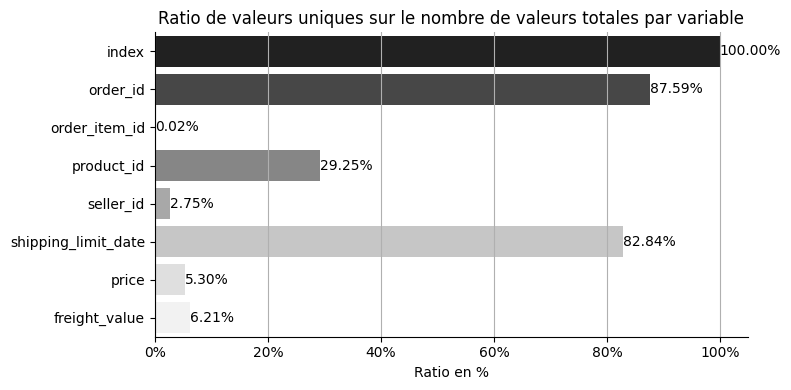

In [155]:
# création d'un ratio de valeur unique par le compte total de valeurs dans chaque variable :
nunique_count_ratio = order_items.nunique() / order_items.count()
# création du plot
fig, ax = plt.subplots(figsize=(8, 4))
(
    sns.barplot(
        y=nunique_count_ratio.index,
        x=nunique_count_ratio.values,
        hue=nunique_count_ratio.index,
        palette="Greys_r",
        ax=ax,
    ).set(
        title="Ratio de valeurs uniques sur le nombre de valeurs totales par variable",
        xlabel="Ratio en %",
        ylabel="",
    )
)
ax.grid(axis="x", visible=True)
ax.xaxis.set_major_formatter(PercentFormatter(1))
show_nums_axes(ax=ax, orient="h", fmt=".2%")
sns.despine()
plt.tight_layout()
plt.show()

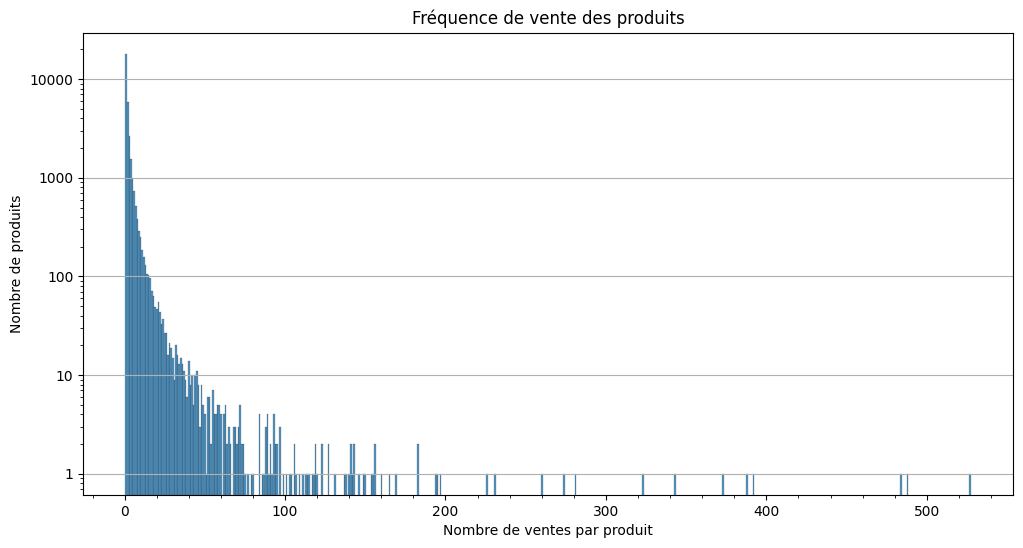

In [156]:
# Création d'un histogramme avec la distribution nombre de ventes par produit sur l'ensemble des produits de la base
fig, ax = plt.subplots(figsize=(12, 6))
(
    order_items["product_id"]
    .value_counts()
    .pipe(sns.histplot, discrete=True, ax=ax)
    .set(
        yscale="log",
        xlabel="Nombre de ventes par produit",
        ylabel="Nombre de produits",
        title="Fréquence de vente des produits",
    )
)
# customisation du plot
ax.yaxis.set_major_formatter(LogFormatter(10))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
ax.grid(axis="y", visible=True)
plt.show()

In [157]:
# Calcul des statistiques descriptives sur le value counts du champs product_id
(order_items["product_id"].value_counts().describe())

count    32951.000000
mean         3.418713
std         10.619709
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        527.000000
Name: count, dtype: float64

On a au total près de 33000 produits vendus sur toutes les commandes avec en moyenne plus de 3 ventes par produit sur nos données.<br>
On distingue des best-sellers dont le maximum s'établit à 527 ventes.<br>
Nous pourrons regarder éventuellement dans la table produit à quelle catégorie ils appartiennent.


Intérressons-nous aux vendeurs :

In [158]:
print("Nombre de vendeurs uniques: ", order_items["seller_id"].nunique())
print(
    "Nombre de produits unique vendus en moyenne par vendeur: ",
    order_items.groupby("seller_id")["product_id"].value_counts().mean(),
)

Nombre de vendeurs uniques:  3095
Nombre de produits unique vendus en moyenne par vendeur:  3.2701463074779378


Ces informations ne devraient pas nous servir dans la segmentation.<br>
Regardons à présent le nombre d'objets moyen dans un panier :

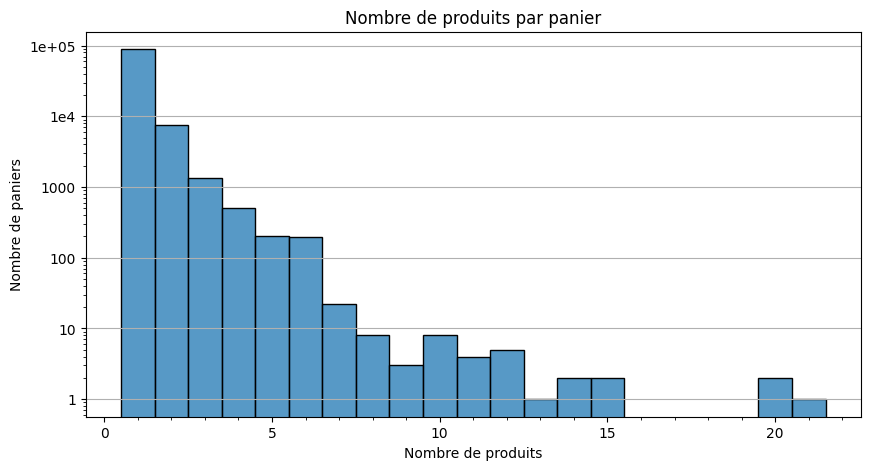

In [159]:
# Histogramme du compte de nombre d'objets dans une commande par commande
fig, ax = plt.subplots(figsize=(10, 5))
(
    sns.histplot(
        x=order_items.groupby("order_id")["order_item_id"].max(), discrete=True, ax=ax
    ).set(
        yscale="log",
        title="Nombre de produits par panier",
        xlabel="Nombre de produits",
        ylabel="Nombre de paniers",
    )
)
ax.yaxis.set_major_formatter(LogFormatter(10))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
ax.grid(axis="y", visible=True)
plt.show()

In [160]:
# Calcul des statiques descriptives sur le nombre d'items maximum par panier
print(order_items.groupby("order_id")["order_item_id"].max().describe())

count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: order_item_id, dtype: float64


La grande majorité des paniers comporte un seul objet en moyenne.<br>
Il y a moins de 10 000 paniers également avec 2 produits et au-delà les paniers se font de plus en plus rares.<br>


Regardons le prix moyen par panier :

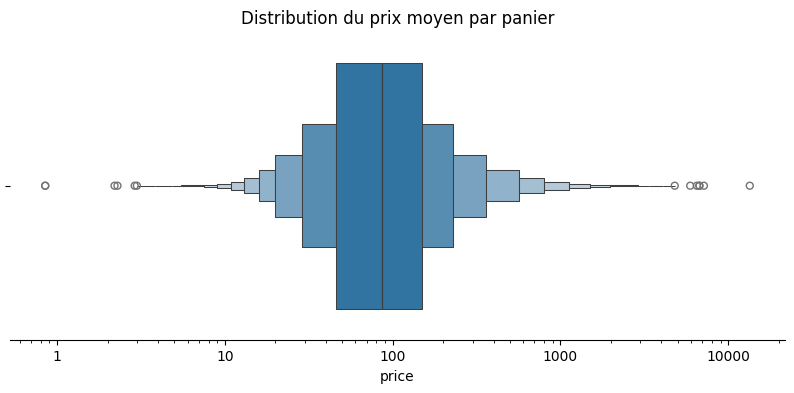

In [161]:
# Boxplot de la distribution du prix moyen par commande
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x=order_items.groupby("order_id")["price"].sum(), ax=ax).set(
    xscale="log", title="Distribution du prix moyen par panier"
)
sns.despine(left=True, right=True, top=True)
ax.xaxis.set_major_formatter(LogFormatter(10))
plt.show()

In [162]:
# Calcul des statistiques descriptives sur la somme des paiements par commandes groupées
order_items.groupby("order_id")["price"].sum().describe()

count    98666.000000
mean       137.754074
std        210.645157
min          0.850000
25%         45.900002
50%         86.900002
75%        149.899994
max      13440.000000
Name: price, dtype: float64

Il suit une distribution log normale avec un prix moyen relativement bien centré.<br>
On a des extrêmes également mais qui restent rares.<br>
Enfin, on peut regarder les frais de port qui sont différents selon les objets par commande ainsi on peut regarder directement leur total :

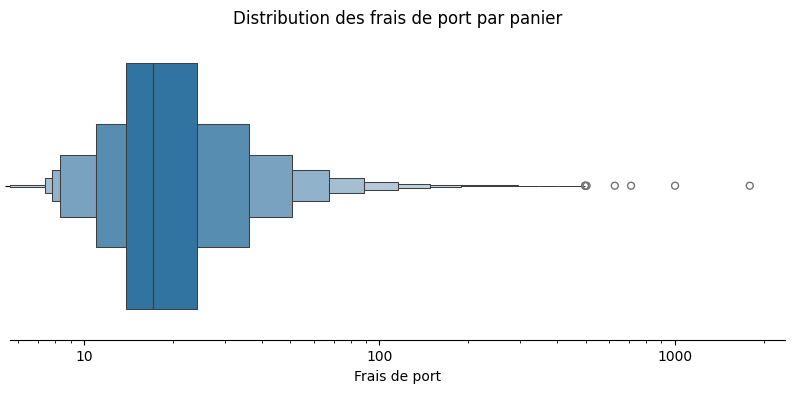

In [163]:
# Boxplot de la distribution des frais de port par commande
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x=order_items.groupby("order_id")["freight_value"].sum(), ax=ax).set(
    xscale="log",
    title="Distribution des frais de port par panier",
    xlabel="Frais de port",
)
sns.despine(left=True, right=True, top=True)
ax.xaxis.set_major_formatter(LogFormatter(10))
plt.show()

In [164]:
# Calcul des statistiques descriptives sur la somme des frais de port des commandes groupées
print(order_items.groupby("order_id")["freight_value"].sum().describe())

count    98666.000000
mean        22.823561
std         21.650909
min          0.000000
25%         13.850000
50%         17.170000
75%         24.040001
max       1794.959961
Name: freight_value, dtype: float64


On a un peu plus de dispersion au niveau des frais de port encore une fois des maximums très élevés comparés à la moyenne.<br>
Enfin on a un champs qui permets de regarder la date limite pour le vendre donne la commande au partenaire logistique.<br>
Dans l'état, il faudrait le lier avec la date d'achat pour qu'il soit significatif mais on peut au moins regarder les stastiques descriptives:


In [165]:
# Calcul des statistiques descriptives sur le champs shipping_limit_date
print(order_items["shipping_limit_date"].describe())

count                           112650
mean     2018-01-07 15:36:52.192685312
min                2016-09-19 00:15:34
25%         2017-09-20 20:57:27.500000
50%                2018-01-26 13:59:35
75%      2018-05-10 14:34:00.750000128
max                2020-04-09 22:35:08
Name: shipping_limit_date, dtype: object


## PRODUCTS

Ce dataset est un noeud entre `SELLERS` et `ORDER_ITEMS`.<br>
Il donne des caractéristiques lié au produit/item et sa catégorie de produit<br>


Il est en lien avec :
* `ORDER_ITEMS` lié par clé `product_id`
* `SELLERS` lié par clé `seller_id`


Voici la description des champs :

In [166]:
# Lecture de la table products sous la forme d'un DataFrame Pandas
products = pd.read_sql_table("products", con=engine)
# Vérification du nombre de duplicatas ainsi que leur nombre
print(f"Nombre de duplicatas dans la table : {products.duplicated().sum()}\n--------")
# affichage de dataframe info
print(products.info())

Nombre de duplicatas dans la table : 0
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       32951 non-null  int64  
 1   product_id                  32951 non-null  object 
 2   product_category_name       32341 non-null  object 
 3   product_name_lenght         32341 non-null  float64
 4   product_description_lenght  32341 non-null  float64
 5   product_photos_qty          32341 non-null  float64
 6   product_weight_g            32949 non-null  float64
 7   product_length_cm           32949 non-null  float64
 8   product_height_cm           32949 non-null  float64
 9   product_width_cm            32949 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ MB
None


On constate un écart de 610 `product_id` avec les valeurs de `product_category_name`.<br>
On a également un léger écart sur les dimensions produits (2). <br>
La catégorie du produit ayant 723 modalités, en fonction de l'utilité de cette variable pour la segmentation, nous conserverons également les valeurs nulles.


Je vais convertir les champs dans un format plus adapté :

In [167]:
products = convert_dtypes(products)

Regardons la prévisualisation :<br>

In [168]:
products.head(5)

,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


On inspecte les ratios de valeurs uniques sur valeur totale sur notre table :

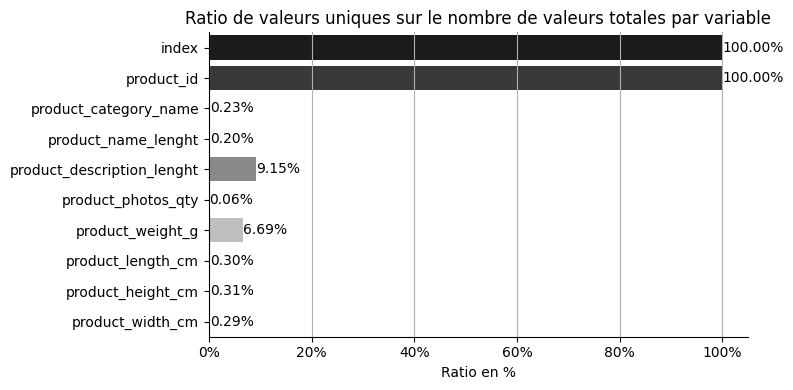

In [169]:
# création d'un ratio de valeur unique par le compte total de valeurs dans chaque variable :
nunique_count_ratio = products.nunique() / products.count()
# création du plot
fig, ax = plt.subplots(figsize=(8, 4))
(
    sns.barplot(
        y=nunique_count_ratio.index,
        x=nunique_count_ratio.values,
        hue=nunique_count_ratio.index,
        palette="Greys_r",
        ax=ax,
    ).set(
        title="Ratio de valeurs uniques sur le nombre de valeurs totales par variable",
        xlabel="Ratio en %",
        ylabel="",
    )
)
ax.grid(axis="x", visible=True)
ax.xaxis.set_major_formatter(PercentFormatter(1))
show_nums_axes(ax=ax, orient="h", fmt=".2%")
sns.despine()
plt.tight_layout()
plt.show()

On a une variable catégorielle, celle du type de produit, qui peut être interréssante, regardons son nombre de modalités :

In [170]:
# Calcul du nombre de valeurs uniques pour le champs product category name
products["product_category_name"].nunique()

73

Il y a beaucoup de modalités différentes et il va être difficile de l'intégrer dans la segmentation.


Regardons les noms des catégories les plus représentées parmi tous les produits :

In [171]:
products["product_category_name"].value_counts(ascending=False)[:20]

product_category_name
cama_mesa_banho                      3029
esporte_lazer                        2867
moveis_decoracao                     2657
beleza_saude                         2444
utilidades_domesticas                2335
automotivo                           1900
informatica_acessorios               1639
brinquedos                           1411
relogios_presentes                   1329
telefonia                            1134
bebes                                 919
perfumaria                            868
fashion_bolsas_e_acessorios           849
papelaria                             849
cool_stuff                            789
ferramentas_jardim                    753
pet_shop                              719
eletronicos                           517
construcao_ferramentas_construcao     400
eletrodomesticos                      370
Name: count, dtype: int64

Pour les autres caractéristiques, qui ont notamment des valeurs manquantes sur certains produits, regardons les statistiques descriptives  :

In [172]:
products.iloc[:, 3:].describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476948,771.495239,2.188986,2276.472412,30.815079,16.937662,23.196728
std,10.245741,635.115234,1.736766,4282.038574,16.914457,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


## TRANSLATION

Ce dataset est donne la traduction en anglais des catégories de produit.<br>


Il est en lien avec :
* `PRODUCTS` lié par clé `product_category_name`

In [173]:
# Lecture de la table translation sous la forme d'un DataFrame Pandas
translation = pd.read_sql_table("translation", con=engine)
# Vérification du nombre de duplicatas ainsi que leur nombre
print(
    f"Nombre de duplicatas dans la table : {translation.duplicated().sum()}\n--------"
)
# affichage de dataframe info
print(translation.info())

Nombre de duplicatas dans la table : 0
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          71 non-null     int64 
 1   product_category_name          71 non-null     object
 2   product_category_name_english  71 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.8+ KB
None


On constate qu'on a deux modalités 'absentes' dans cette table. <br>
Regardons quelles sont ces différences :

In [174]:
# Différence des sets des deux champs
set(products["product_category_name"]) - set(translation["product_category_name"])

{nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

# PHASE PREPARATOIRE DES DONNEES

Pour faciliter la suite des traitements, on effectue une requête qui nous retourner l'ensemble des clients uniques avec toutes leurs commandes et leurs détails, avec des filtres configurés sur :
* Filtre sur les dates d'achat borné (05/10-2016 au 27-08-2018)
* Filtre sur toutes les commandes qui n'ont pas encore de date de livraison réelle
* Filtre sur les 2 commandes avec une échéance de 0
* Filtre sur les commandes sans type de paiement défini
* Filtre sur les commandes sans review score
* Filtre sur les commandes qui auraient des produits sans prix défini...

In [175]:
# Définition de la requête SQL pour réunir toutes les informations nécessaire pour calculer tous les agrégations nécessaires
query = """
SELECT customers.customer_id, customer_unique_id,
o.order_id, o.order_status, o.order_purchase_timestamp, o.order_estimated_delivery_date, o.order_delivered_customer_date,
reviews.review_score,
pymts.payment_type, pymts.payment_installments, pymts.payment_value,
item.order_item_id, item.product_id, item.price, item.freight_value,
p.product_category_name, p.product_photos_qty, p.product_weight_g, p.product_length_cm, p.product_height_cm, p.product_width_cm,
t.product_category_name_english
FROM customers
-- On effectue les opérations de merge à partir de la table customers vers orders
LEFT JOIN orders AS o
USING(customer_id)
LEFT JOIN order_items AS item
USING(order_id)
LEFT JOIN order_reviews AS reviews
USING(order_id)
LEFT JOIN order_pymts AS pymts
USING(order_id)
-- On effectue les opérations de merge avec les produits et la traduction des catégories
LEFT JOIN products AS p
ON item.product_id = p.product_id
LEFT JOIN translation AS t
ON p.product_category_name = t.product_category_name
-- On filtre les dates de commande vues lors de l'analyse exploratoire
WHERE date(o.order_purchase_timestamp) BETWEEN '2016-10-05' AND '2018-08-27'
    -- On filtre les commandes qui ont été livrées, avec une date de livraison
    AND o.order_delivered_customer_date IS NOT NULL
    -- On filtre les rares commandes qui indiquent 0 échéance de paiement
    AND pymts.payment_installments > 0
    -- On filtre les commandes dont le type de paiement n'est pas défini
    AND pymts.payment_type NOT LIKE 'not_defined'
    -- On filtre les commandes sans review score
    AND reviews.review_score IS NOT NULL
    -- On filtre les produits qui n'ont pas de prix
    AND item.price IS NOT NULL;
"""
# Création d'un dataframe avec le résultat de la requête
data = pd.read_sql_query(query, con=engine)
# On affiche les dimensions du dataframe
print("Dimensions du jeu de donnée fusionné: ", data.shape)

Dimensions du jeu de donnée fusionné:  (114714, 22)


In [176]:
# Affichage de l'info du dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114714 entries, 0 to 114713
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    114714 non-null  object 
 1   customer_unique_id             114714 non-null  object 
 2   order_id                       114714 non-null  object 
 3   order_status                   114714 non-null  object 
 4   order_purchase_timestamp       114714 non-null  object 
 5   order_estimated_delivery_date  114714 non-null  object 
 6   order_delivered_customer_date  114714 non-null  object 
 7   review_score                   114714 non-null  int64  
 8   payment_type                   114714 non-null  object 
 9   payment_installments           114714 non-null  int64  
 10  payment_value                  114714 non-null  float64
 11  order_item_id                  114714 non-null  int64  
 12  product_id                    

On constate que les champs dates n'ont pas été convertis. <br>
On exécute notre fonction d'optimisation des data types:

In [177]:
# Exécution de la fonction de convertissage des dtypes
data = convert_dtypes(data)
# Affichage de l'info actualisé
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114714 entries, 0 to 114713
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    114714 non-null  object        
 1   customer_unique_id             114714 non-null  object        
 2   order_id                       114714 non-null  object        
 3   order_status                   114714 non-null  category      
 4   order_purchase_timestamp       114714 non-null  datetime64[ns]
 5   order_estimated_delivery_date  114714 non-null  datetime64[ns]
 6   order_delivered_customer_date  114714 non-null  datetime64[ns]
 7   review_score                   114714 non-null  uint8         
 8   payment_type                   114714 non-null  category      
 9   payment_installments           114714 non-null  uint8         
 10  payment_value                  114714 non-null  float32       
 11  

On note galement que les caractéristiques de certaines produits sont nulles car ils n'ont pas eu de données associées dans la base produit. <br>
Je déciderai plus tard s'il faut calculer des aggrégations sur ces colonnes ou pas.<br>
Enfin j'enregistre le dataframe sous format pickle pour pouvoir le réutiliser dans le prochain notebook sur le clustering.

In [178]:
# On sauvegarde sous un fichier pickle le dataframe
data.to_pickle("donnees_clients.pkl")

# SEGMENTATION RFM

## CREATION DES VARIABLES RFM

A titre de rappel, voici les informations nécessaires à savoir sur les variables de la segmentation RFM :
* **Récence (R)** :
    * Définition : La récence mesure le temps écoulé depuis la dernière interaction ou transaction du client.
    * Calcul : Récence = Date actuelle - Date de la dernière transaction.
    * Exemple : Si un client a effectué sa dernière transaction il y a 10 jours, la récence est de 10 jours.
* **Fréquence (F)** :
    * Définition : La fréquence mesure le nombre de transactions effectuées par le client sur une période donnée.
    * Calcul : Fréquence = Nombre total de transactions dans une période donnée.
    * Exemple : Si un client a effectué 5 transactions au cours des 6 derniers mois, la fréquence est de 5.
* **Montant (M)** :
    * Définition : Le montant mesure la valeur monétaire totale des transactions effectuées par le client sur une période donnée.
    * Calcul : Montant = Somme des montants dépensés par le client dans une période donnée.
    * Exemple : Si un client a dépensé 500 euros au cours des 6 derniers mois, le montant est de 500 euros.


On commence avec le calcul de la **Récence**:


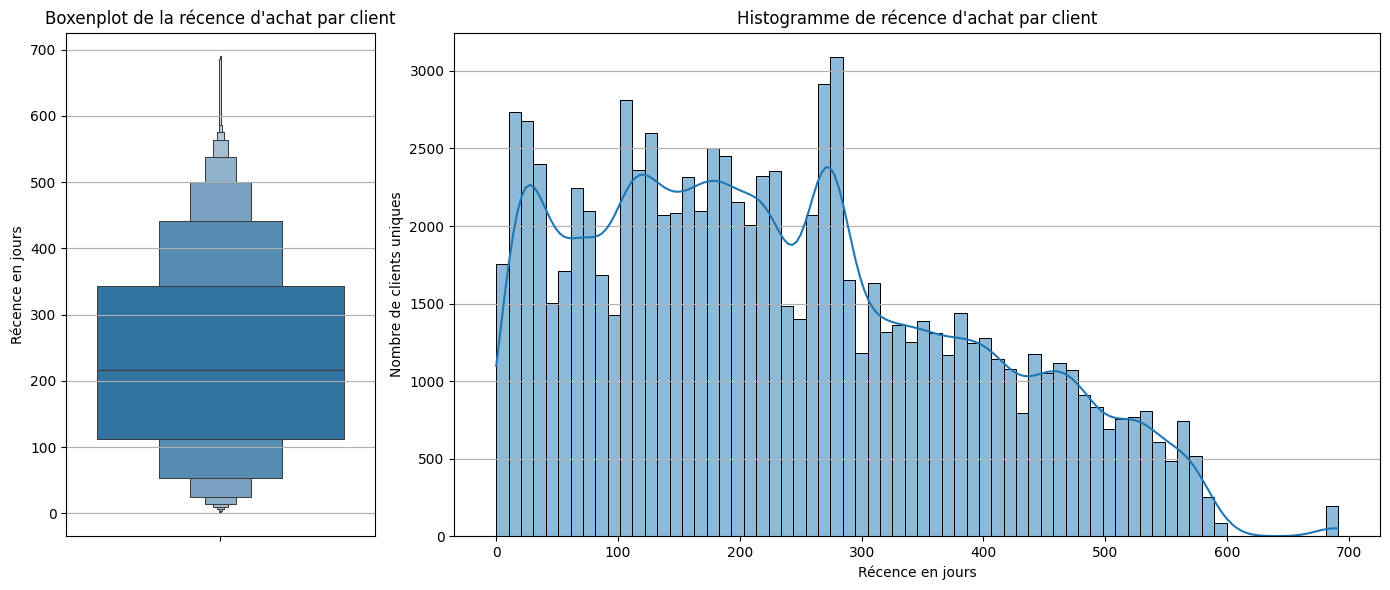

In [179]:
# Création d'un nouveau champs qui calcule le delta entre date d'achat et le dernier jour d'achat dans la base
data = data.assign(
    **{
        "delay_purchase_to_now": lambda x: (
            x["order_purchase_timestamp"].max() - x["order_purchase_timestamp"]
        ).dt.days,
    }
)
# Assignation de la récence avec le nombre de jours depuis le dernier achat par le par client unique
recence = data.groupby("customer_unique_id")["delay_purchase_to_now"].min()
# Création d'une figure avec 2 plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [1, 3]})
# Histogramme de la récence d'achat par client unique
sns.histplot(recence, kde=True, ax=ax[1]).set(
    title="Histogramme de récence d'achat par client",
    xlabel="Récence en jours",
    ylabel="Nombre de clients uniques",
)
ax[1].grid(axis="y")
# Boxenplot de la récence d'achat par client unique
sns.boxenplot(recence, ax=ax[0]).set(
    title="Boxenplot de la récence d'achat par client",
    ylabel="Récence en jours",
)
ax[0].grid(axis="y")
plt.tight_layout()
plt.show()

In [180]:
# Affichage des statistiques descriptive sur la récence par client en jours
print(recence.describe())

count    92643.000000
mean       235.172522
std        152.175502
min          0.000000
25%        112.000000
50%        216.000000
75%        343.000000
max        691.000000
Name: delay_purchase_to_now, dtype: float64


Sur l'ensemble de nos clients et au vu de ce que l'analyse des commandes nous a montré, on constate une asymétrie de la distribution sur la droite (récence éloignée en jours).<br>
Cela siginifie **qu'il y a davantage de clients en volume avec une récence 'courte'**.<br>
C'est un bon indicateur pour l'entreprise.<br>
**La moyenne de la récence est de 235 jours** alors que **le maximum est à 691 jours**.


Concernant la **Fréquence**, on l'a déjà regardé lors de l'analyse.<br>
Observons la distribution : 

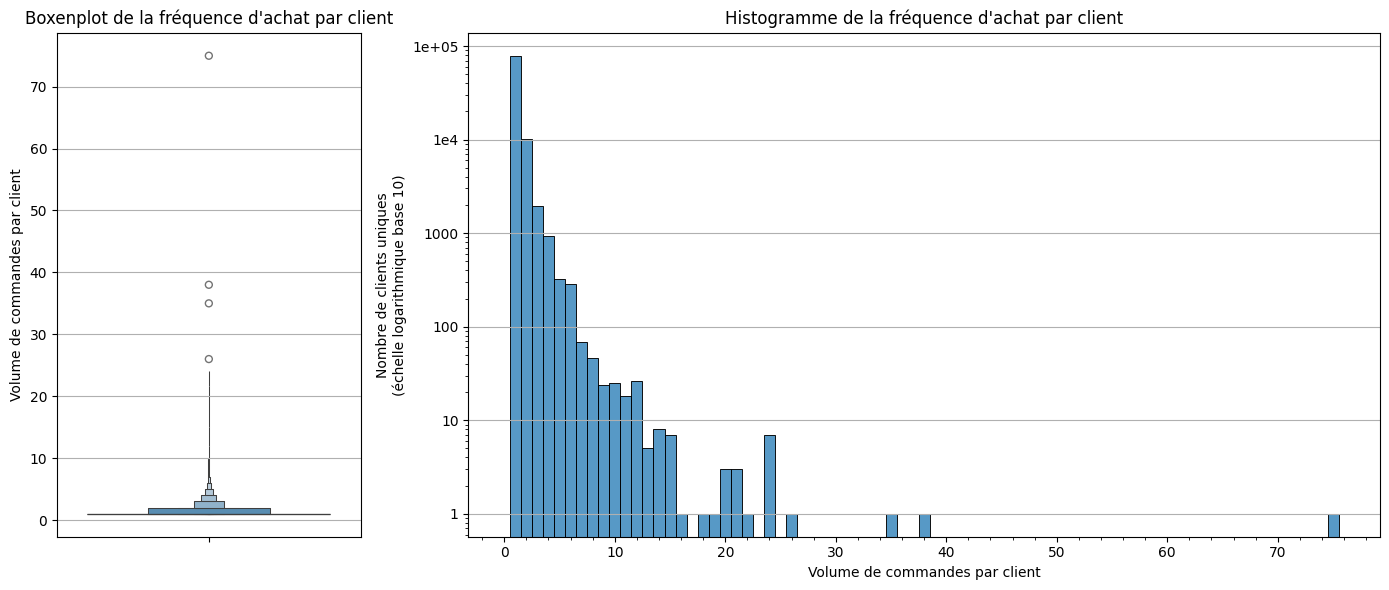

In [181]:
# Assignation de la fréquence par client sous une variable
frequence = data.groupby("customer_unique_id")["order_id"].count()
# Création d'une figure avec 2 plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [1, 3]})
# Histogramme de la fréquence d'achat par client unique
sns.histplot(frequence, discrete=True, ax=ax[1]).set(
    title="Histogramme de la fréquence d'achat par client",
    xlabel="Volume de commandes par client",
    ylabel="Nombre de clients uniques\n(échelle logarithmique base 10)",
    yscale="log",
)
ax[1].yaxis.set_major_formatter(LogFormatter())
ax[1].xaxis.set_minor_locator(MultipleLocator(2))
ax[1].grid(axis="y")
# Boxenplot de la fréquence d'achat par client unique
sns.boxenplot(frequence, ax=ax[0]).set(
    title="Boxenplot de la fréquence d'achat par client",
    ylabel="Volume de commandes par client",
)
ax[0].grid(axis="y")
plt.tight_layout()
plt.show()

In [182]:
# Affichage des statistiques descriptives sur la fréquence par client unique
print(frequence.describe())

count    92643.000000
mean         1.238237
std          0.845793
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         75.000000
Name: order_id, dtype: float64


La **Fréquence** est hautement déséquilibrée avec une asymétrie logarithmique sur la droite (nombre de commandes élevées par client unique).<br>
La très grande majorité des clients, plus de 75% de la population, ont seulement une commande à leur actif sur les données étudiées.<br>
Il y a environ 10% des clients qui ont fait 2 commandes et seulement 1% des clients qui font 4 commandes ou +. <br>
On ne peut pas compresser la variable en utilisant une compression logarithmique du fait que le nombre de commandes doit forcément être un entier.<br>
En soi, cette variable ne sera pas vraiment informative dans le calcul de la segmentation RFM.


Enfin regardons la variable **Monetary** par client unique:

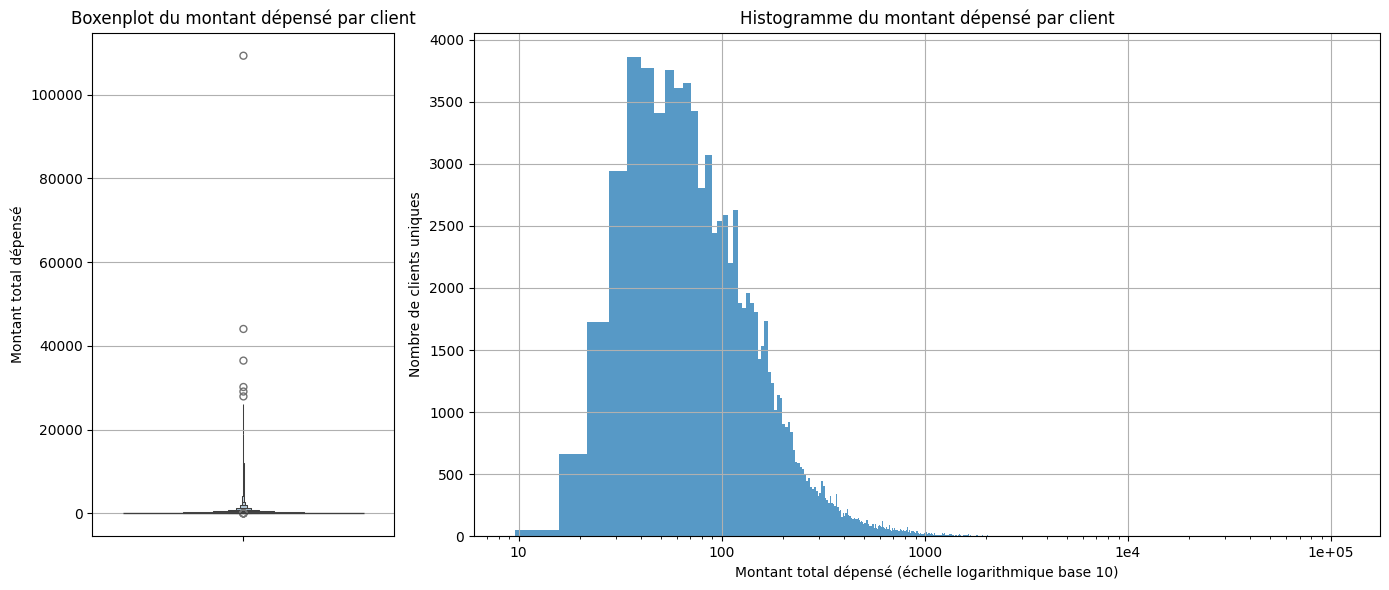

In [183]:
# Assignation de la variable monetary pour le montant total d'achat par client unique
monetary = data.groupby("customer_unique_id")["payment_value"].sum()
# Création d'une figure avec 2 plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [1, 3]})
# Histogramme de la récence d'achat par client unique
sns.histplot(monetary, ax=ax[1]).set(
    title="Histogramme du montant dépensé par client",
    xlabel="Montant total dépensé (échelle logarithmique base 10)",
    ylabel="Nombre de clients uniques",
    xscale="log",
)
ax[1].xaxis.set_major_formatter(LogFormatter())
ax[1].grid(axis="both")
# Boxenplot de la récence d'achat par client unique
sns.boxenplot(monetary, ax=ax[0]).set(
    title="Boxenplot du montant dépensé par client",
    ylabel="Montant total dépensé",
)
ax[0].grid(axis="y")
plt.tight_layout()
plt.show()

In [184]:
# Affichage des statistiques descriptives sur le montant dépensé par client unique
print(monetary.describe())

count     92643.000000
mean        212.078781
std         630.249146
min           9.590000
25%          63.790001
50%         113.019997
75%         201.985001
max      109312.640625
Name: payment_value, dtype: float64


On constate à nouveau une asymétrie extrême vers la droite (montant plus élevé dépensé par client) avec des sommes montant jusqu'à 100 000 real dépensés par un client !<br>
Or, on constate que la moyenne de dépense par client est de 212 real avec 75% de la population en dessous de cette moyenne.<br>
Pour le découpage de la variable, on sera obligé de tenir compte de cette échelle logarthmique.

## TRANSFORMATION DES VARIABLES RFM

Il est nécessaire de mettre à une échelle comparable l'ensemble des variables RFM.<br>
Pour réaliser cette démarche, on créé un dataframe avec nos 3 variables RFM et en index les identifiants de client unique:

In [185]:
# On regroupe sous un dataframe les 3 champs R, F et M.
rfm_df = (
    pd.concat(
        [recence.sort_index(), frequence.sort_index(), monetary.sort_index()], axis=1
    )
    .rename(columns={"order_id": "frequence", "payment_value": "monetary"})
    .reset_index()
)
# On prévisualise le head
display(rfm_df.head(5))

,customer_unique_id,delay_purchase_to_now,frequence,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,109,1,141.899994
1,0000b849f77a49e4a4ce2b2a4ca5be3f,112,1,27.190001
2,0000f46a3911fa3c0805444483337064,535,1,86.220001
3,0000f6ccb0745a6a4b88665a16c9f078,319,1,43.619999
4,0004aac84e0df4da2b147fca70cf8255,286,1,196.889999


In [186]:
# Affichage des dimensions du tableau avec les clients uniques
print("Dimensions du nouveau tableau par client unique: ", rfm_df.shape)

Dimensions du nouveau tableau par client unique:  (92643, 4)


A présent, le but est d'ordaniliser nos variables RFM sous forme de quintile afin qu'ils soient tous à la même échelle.<br>
On sait déjà que cela poser problème pour la fréquence et même le montant monétaire car les populations sont très mal réparties.<br>


Voici les transformations que l'on va effectuer:
* `recence` : méthode des quintiles
* `frequence` : clip de 1 à 5 (regroupement de tous les clients avec 5 commandes ou + à 5)
* `monetary` : méthode des quintiles sur la variable transformée en log base 10

In [187]:
# définition des labels
labels = [*range(1, 6)]
# Création des nouvelles colonnes sous forme ordinalisé de 1 à 5
rfm_df = rfm_df.assign(
    **{
        "r": lambda x: x["delay_purchase_to_now"].transform(
            lambda x: pd.qcut(
                x, 5, labels=labels[::-1]
            )  # attention, pour la récence, les délais courts ont un score plus élevé
        ),
        "f": lambda x: x["frequence"].clip(lower=1, upper=5),
        "m": lambda x: x["monetary"]
        .transform(lambda x: np.log(x))
        .transform(lambda x: pd.qcut(x, 5, labels=labels)),
    }
).assign(  # Ensuite on créé une nouvelle colonne qui est le score rfm concaténé des 3 précédentes notes
    **{
        "score_rfm": lambda x: (
            x["r"].astype("str") + x["f"].astype("str") + x["m"].astype("str")
        ),
        "score_rm": lambda x: (x["r"].astype("str") + x["m"].astype("str")).astype(
            "int"
        ),
    }
)
# Affichage du head après transformation
display(rfm_df.head(5))

,customer_unique_id,delay_purchase_to_now,frequence,monetary,r,f,m,score_rfm,score_rm
0,0000366f3b9a7992bf8c76cfdf3221e2,109,1,141.899994,4,1,4,414,44
1,0000b849f77a49e4a4ce2b2a4ca5be3f,112,1,27.190001,4,1,1,411,41
2,0000f46a3911fa3c0805444483337064,535,1,86.220001,1,1,2,112,12
3,0000f6ccb0745a6a4b88665a16c9f078,319,1,43.619999,2,1,1,211,21
4,0004aac84e0df4da2b147fca70cf8255,286,1,196.889999,2,1,4,214,24


## APPLICATION DE LA SEGMENTATION

On passa à l'étape où il faut choisir le nombre de segments à représenter.<br>
On va définir les bases que l'on nous a communiquées, à savoir les segments de la précédente matrice RFM, pour voir si la matrice a évolué.


On va commencer par tester une segmentation avec 6 possibilités:
* **Champions**
* **Loyaux**
* **Loyalistes potentiels**
* **A réactiver**
* **A risque**
* **Hibernation**

In [188]:
# Définir les segments RFM avec une méthode de filtrage basé sur des boucles if-elif-else
def segment_rfm_6(value):
    # Docstring de la fonction
    """
    Cette fonction permet d'assigner un segment RFM à un client en fonction de ses scores R, F et M
    Arguments:
    value -- tuple de 3 valeurs (r, f, m)
    Return:
    str -- segment RFM
    """
    # On assigne les valeurs de r, f et m
    r, f, m = int(value[0]), int(value[1]), int(value[2])
    # On assigne les segments en fonction des scores r, f et m
    r, f, m = int(value[0]), int(value[1]), int(value[2])
    if r >= 4 and f >= 2 and m >= 4:
        return "Champions"
    elif r >= 4 and f >= 2:
        return "Clients fidèles"
    elif r >= 4:
        return "Potentiellement fidèles"
    elif r <= 2 and f <= 2 and m <= 2:
        return "En hibernation"
    elif r <= 2:
        return "À risque"
    else:
        return "Nouveaux clients"

Je realise la première segmentation RFM en fonction des segments définis par ma fonction :

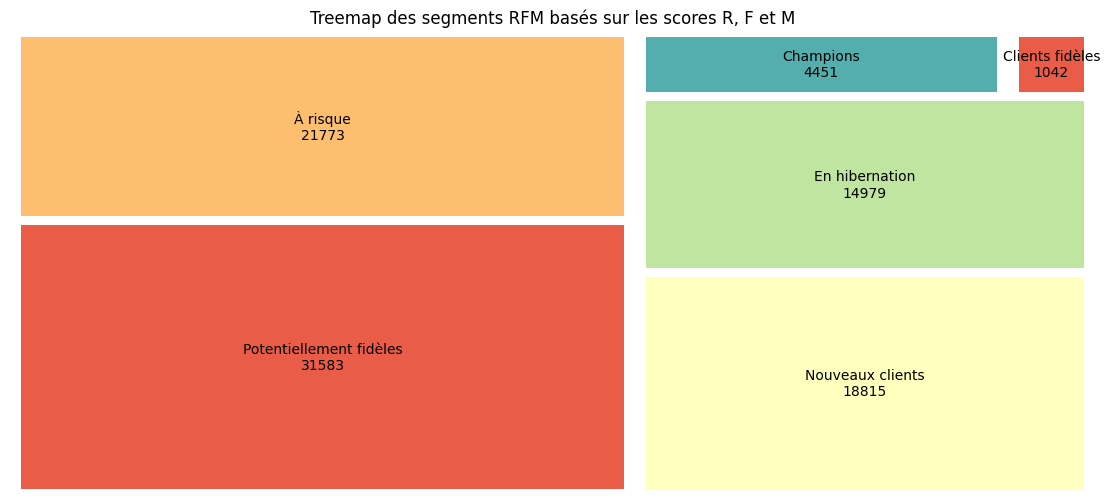

In [189]:
# Création de la colonne Segment avec l'application de la segmentation rm
segment = rfm_df["score_rfm"].apply(segment_rfm_6)
# Création des arguments personnalisés du treemap
sizes = sq.normalize_sizes(segment.value_counts(), 100, 100)
labels = [
    f"{index}\n{values}"
    for index, values in zip(segment.value_counts().index, segment.value_counts())
]
colors = sns.color_palette("Spectral", 5)
# Plot du Treemap
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title("Treemap des segments RFM basés sur les scores R, F et M")
ax.axis("off")
sq.plot(sizes=sizes, label=labels, color=colors, alpha=1, pad=0.5, ax=ax)
plt.show()

On avait déjà indiqué que le Fréquence n'était pas très informative et on le constate ici car nous avons des segments très déséquilibrés en taille. <br>
Formuler des objectifs marketing différent sur chaque segment ne serait pas très efficace.<br>
Dans ce cas, nous pouvons établir des segments basés uniquement sur les scores R et M et déterminer des segments adaptés :
* **Champions**
* **Récents**
* **Prometteurs**
* **Clients à ne pas perdre**
* **Clients en hibernation**

In [190]:
# Fonction de segmentation avec match-case utilisant des entiers beaucoup plus simple à configurer et modifier
def segment_rm_5(value):
    # Docstring de la fonction
    """
    Cette fonction permet d'assigner un segment RM à un client en fonction de ses scores R et M
    Arguments:
    value -- tuple de 2 valeurs (r, m)
    Return:
    str -- segment RFM
    """
    match value:
        case 44 | 45 | 54 | 55:
            return "Champions"
        case 34 | 35 | 43 | 53:
            return "Récents"
        case 24 | 25 | 32 | 33 | 42 | 52:
            return "Prometteurs"
        case 14 | 15 | 23 | 31 | 41 | 51:
            return "Clients à ne pas perdre"
        case _:
            return "Clients en hibernation"

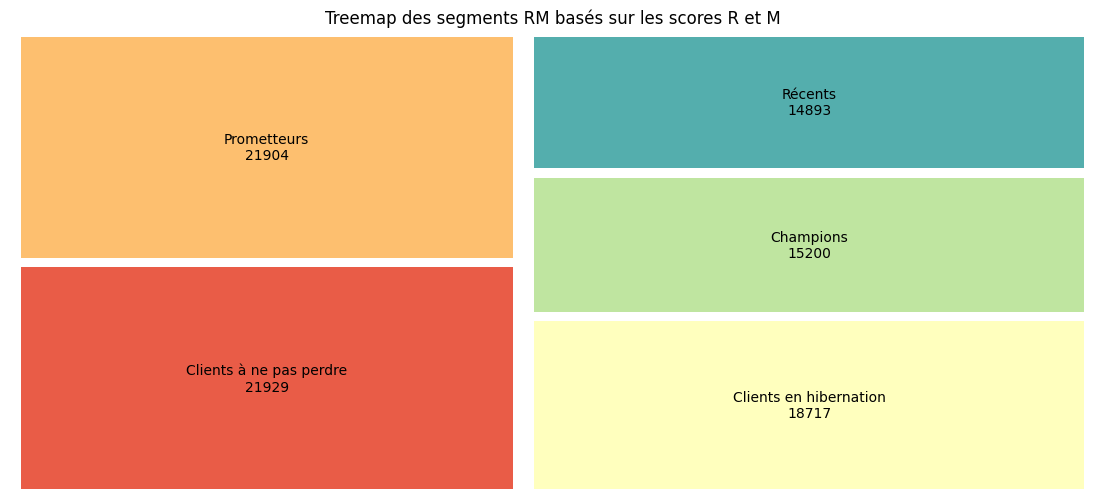

In [191]:
# Création de la colonne Segment avec l'application de la segmentation
segment = rfm_df["score_rm"].apply(segment_rm_5)
# Création des arguments personnalisés du treemap
sizes = sq.normalize_sizes(segment.value_counts(), 100, 100)
labels = [
    f"{index}\n{values}"
    for index, values in zip(segment.value_counts().index, segment.value_counts())
]
colors = sns.color_palette("Spectral", 5)
# Plot du Treemap
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title("Treemap des segments RM basés sur les scores R et M")
ax.axis("off")
sq.plot(sizes=sizes, label=labels, color=colors, alpha=1, pad=0.5, ax=ax)
plt.show()

On obtient une matrice beaucoup plus adaptée avec 5 segments pour des stratégies marketing basée sur ces différents segments.